In [1]:
%matplotlib inline

In [2]:
# Thomas Ax=f 푸는 방법:  A는 alpha, beta, gamma로 이루어진 삼각행렬
def thomas(alpha, beta, gamma, f):
    n = len(f)
    v = np.zeros(n)
    [aa, dd, cc, bb] = map(np.array, [alpha, beta, gamma, f])
    for i in range(1, n):
        mult = aa[i]/dd[i-1]
        dd[i] = dd[i] - mult*cc[i-1]
        bb[i] = bb[i] - mult*bb[i-1]
    v[n-1] = bb[n-1]/dd[n-1]
    for i in range(n-2, -1, -1):
        v[i] = (bb[i] - cc[i]*v[i+1])/dd[i]
    return v

In [3]:
def setPlotStyle():    
    mat.rcParams['font.size'] = 10
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 300
    mat.rcParams['savefig.dpi'] = 300

In [4]:
import matplotlib as mat
setPlotStyle()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import time

start_time = time.time()

facevalue = 100 #액면가격
R=3       #x,y의 최대값

x_volatility = 0.286
y_volatility = 0.547
rho = 0.5371    #x와 y의 상관계수
r = 0.0195 #무위험이자율

Nx=61   #x방향의 점들이 갯수
Ny = Nx
h = R/Nx  #점 간격
x0 = 1    
y0 = 1
x = np.linspace(0, R, Nx)  #x의 이산공간
y = x
T=1088/365           #만기
Nt = int(365*T)
dt = T/Nt 
lst = [Nx, Ny]
[u, ku, old_u, old_ku] = map(np.zeros, [lst, lst, lst, lst]) #u: no-knock-in,  ku: knock-in 때의 가격

deltax = np.zeros([Nx, Ny])
deltay = np.zeros([Nx, Ny])
gammax = np.zeros([Nx, Ny])
gammay = np.zeros([Nx, Ny])
theta = np.zeros([Nx, Ny])
crossgamma = np.zeros([Nx, Ny])

kdeltax = np.zeros([Nx, Ny])
kdeltay = np.zeros([Nx, Ny])
kgammax = np.zeros([Nx, Ny])
kgammay = np.zeros([Nx, Ny])
ktheta = np.zeros([Nx, Ny])
kcrossgamma = np.zeros([Nx, Ny])

us = []
deltaxs = []
deltays = []
gammaxs = []
gammays = []
crossgammas = []

kus = []
kdeltaxs = []
kdeltays = []
kgammaxs = []
kgammays = []
kcrossgammas = []

coupon_rate=np.array([3., 2.5, 2., 1.5, 1., 0.5]) * 0.091

step = np.array([184, 363, 545, 727, 910, 1088])

strike_price=([0.7, 0.8, 0.8, 0.85, 0.85, 0.85])
dummy = 0.091 * 3.
kib = 0.45

# Initial condition
for i in range(0, Nx):
    for j in range(0, Ny):
        if (x[i]<kib*x0 or y[j]<kib*y0):
            u[i,j] = np.minimum(x[i], y[j])/x0 * facevalue  #knock-in 아닌데도 이렇게 해야 하나? 한번이라도 barrier치면 u=ku로 바뀜
            ku[i,j] = np.minimum(x[i], y[j])/x0 * facevalue
        elif (x[i] < strike_price[0]*x0 or y[j] < strike_price[0]*x0):
            u[i,j] = facevalue*(1.+dummy)
            ku[i,j] = np.minimum(x[i], y[j])/x0 * facevalue
        else:
            u[i,j] = facevalue*(1.+coupon_rate[0])
            ku[i,j] = facevalue*(1.+coupon_rate[0])
    
initial_u = u.copy()
initial_ku = ku.copy()

[ax, dx, cx, ay, dy, cy] = map(np.zeros, [Nx-2, Nx-2, Nx-2, Ny-2, Ny-2, Ny-2])
ax[:] = -0.5 * (x_volatility*x[1:Nx-1]/h)**2 + 0.5*r*x[1:Nx-1]/h
dx[:] = 1/dt + (x_volatility*x[1:Nx-1]/h)**2 + r*0.5
cx[:] = -0.5 * (x_volatility*x[1:Nx-1]/h)**2 - 0.5*r*x[1:Nx-1]/h

ax[Nx-3] = ax[Nx-3] - cx[Nx-3]
dx[Nx-3] = dx[Nx-3] + 2*cx[Nx-3]

ay[:] = -0.5 * (y_volatility*y[1:Ny-1]/h)**2 + 0.5*r*y[1:Ny-1]/h
dy[:] = 1/dt + (y_volatility*y[1:Ny-1]/h)**2 + r*0.5
cy[:] = -0.5 * (y_volatility*y[1:Ny-1]/h)**2 - 0.5*r*y[1:Ny-1]/h

ay[Ny-3] = ay[Ny-3] - cy[Ny-3]
dy[Ny-3] = dy[Ny-3] + 2*cy[Ny-3]

tag=0

bx = np.zeros(Nx-2)
by = np.zeros(Ny-2)

100%|█████████████████████████████████████████████████████████████████████| 1088/1088 [00:15<00:00, 71.55it/s]


Price=[[39.89064587]]
Price=[[39.78884706]]
time: 310.1076


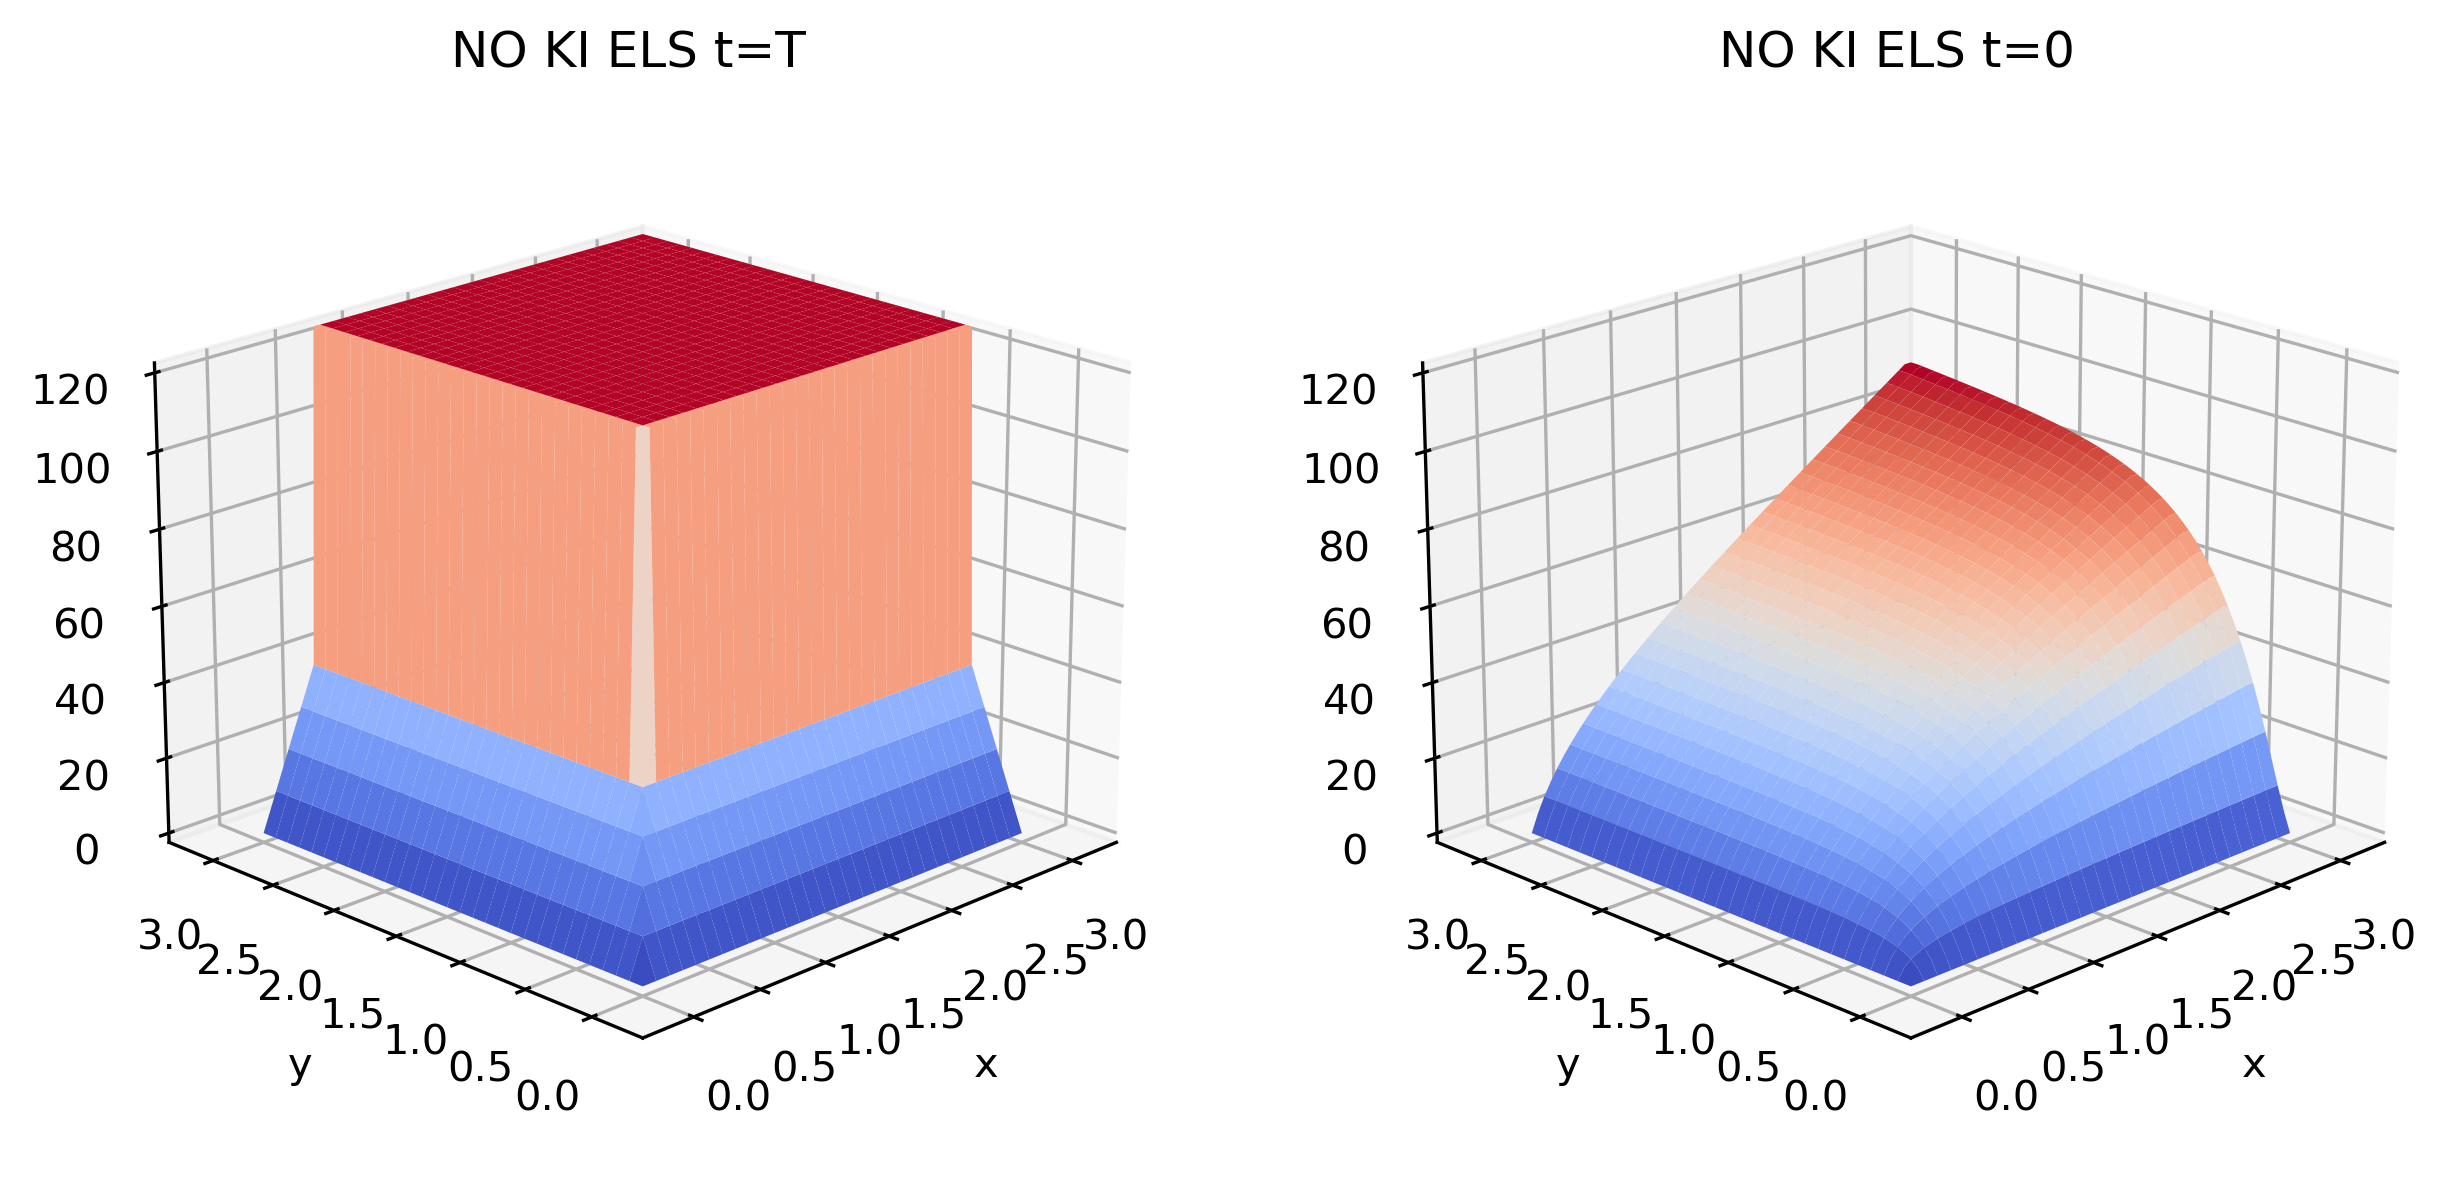

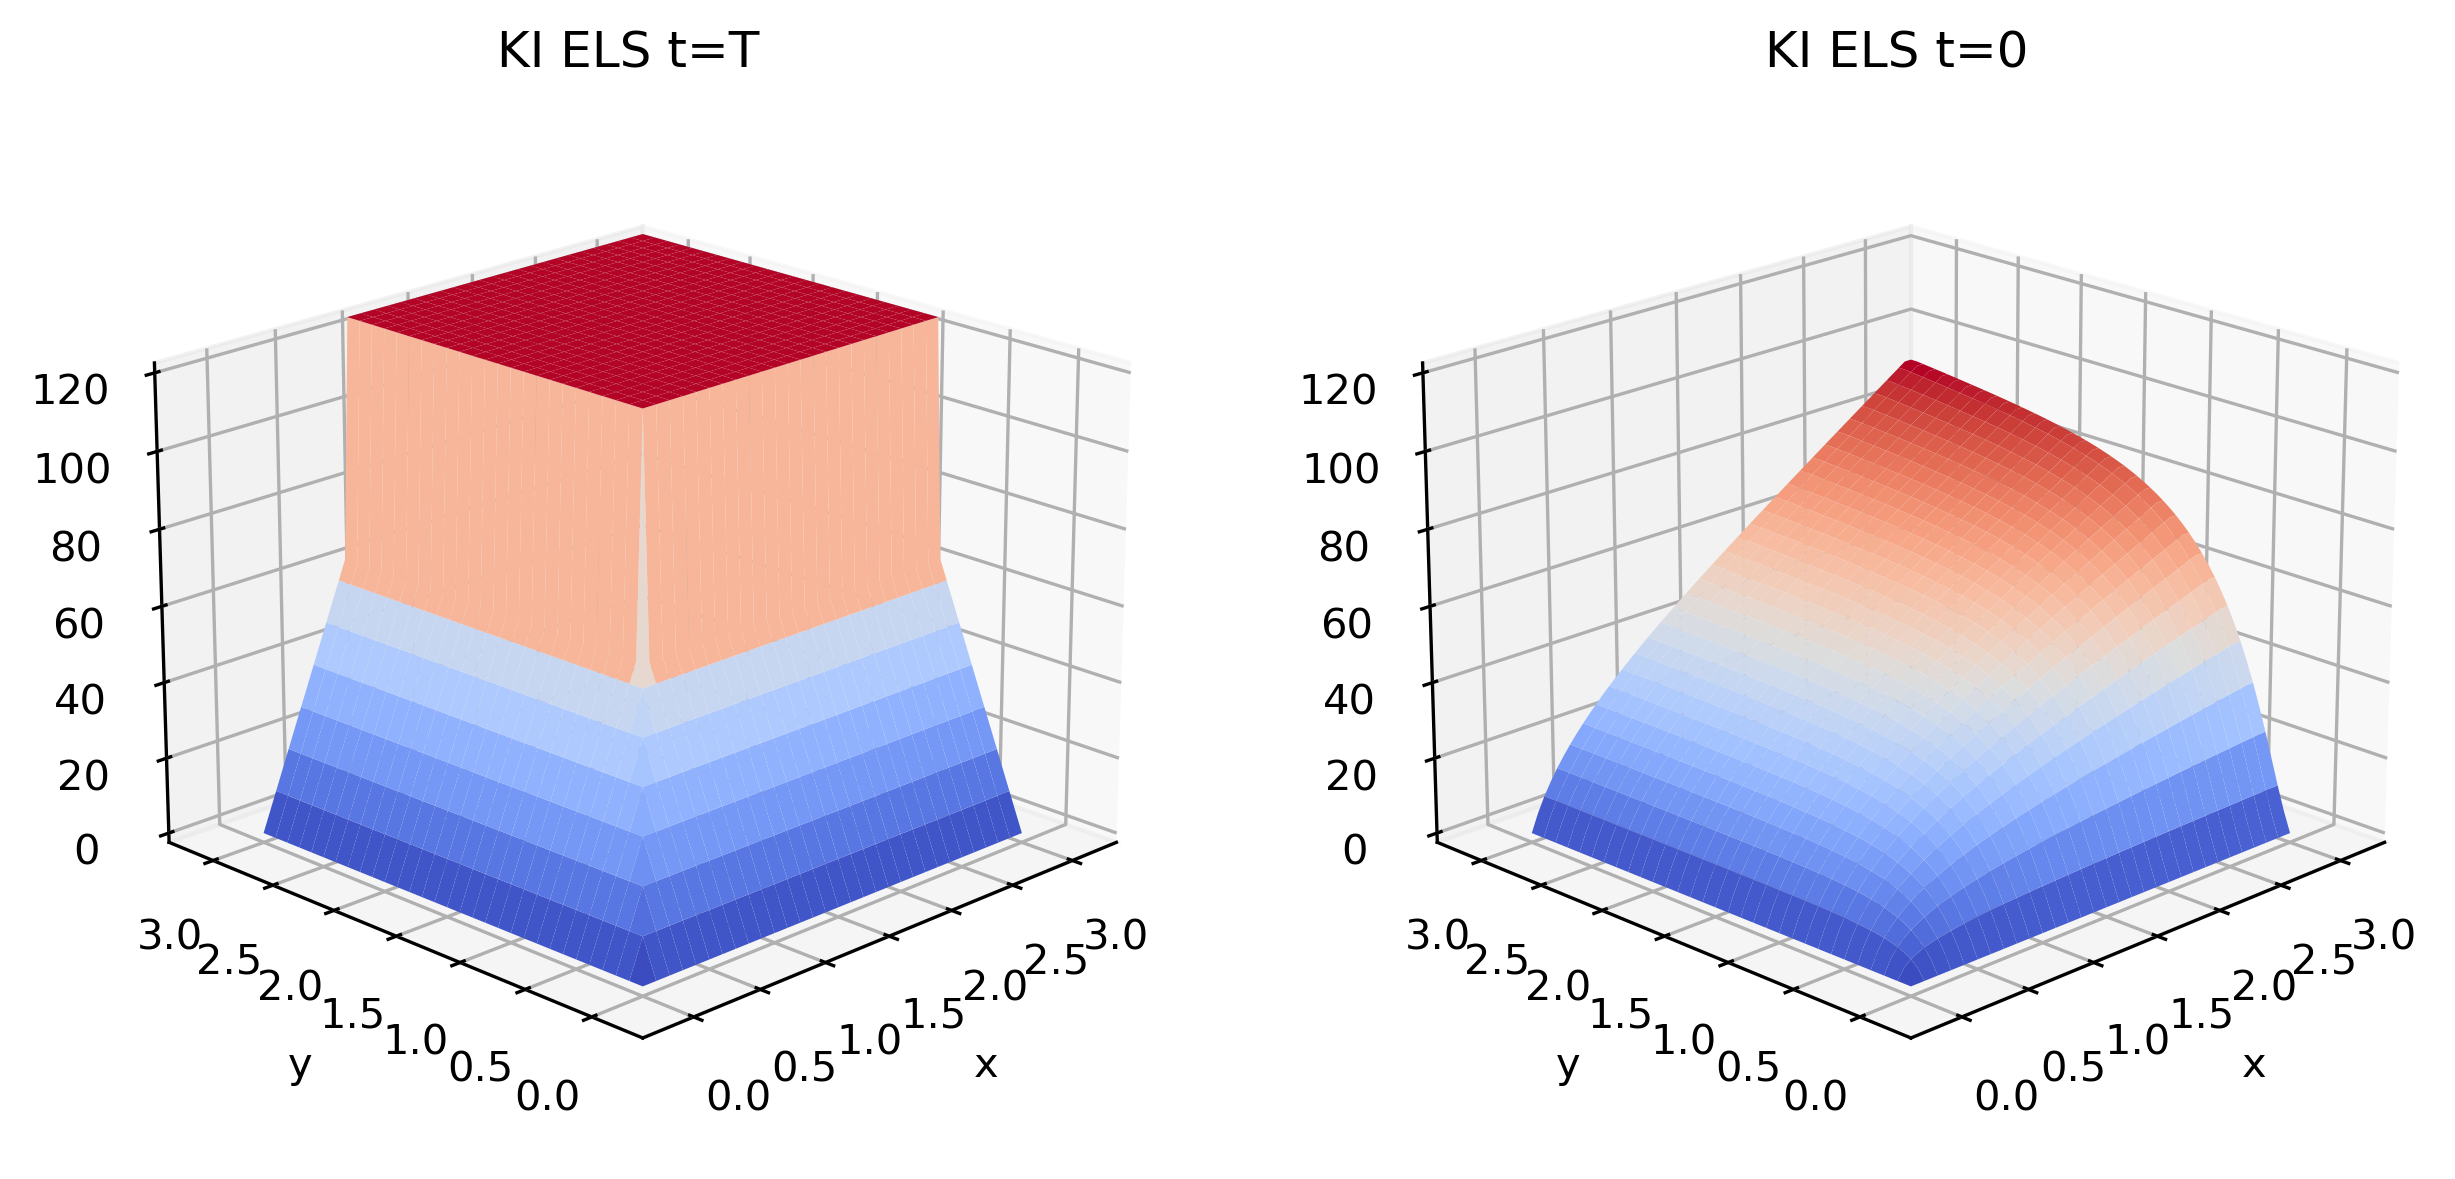

In [19]:
for n in tqdm(range(0, Nt)):
    if (n==step[tag]):
        gx = np.min(np.where(x>=x0*strike_price[tag+1]))
        gy = np.min(np.where(y>=y0*strike_price[tag+1]))
        
        # Autocall condition
        u[gx:Nx-1, gy:Ny-1] = facevalue * (1.+coupon_rate[tag+1])
        ku[gx:Nx-1, gy:Ny-1] = facevalue * (1.+coupon_rate[tag+1])
        
        tag+=1
        
    gx = np.min(np.where(x>=x0*kib))
    gy = np.min(np.where(y>=y0*kib))
    
    # u = ku condition(under kib)
    u[:, 0:gy+1] = ku[:, 0:gy+1]
    u[0:gx+1, :] = ku[0:gx+1, :]
    old_u = u
    old_ku = ku
    
    u_before = old_u.copy()
    
    # u에 대해서 X축으로 푼다
    for j in range(1, Ny-1):
        bx[0:Nx-1] = old_u[1:Nx-1, j]/dt  \
                       +  0.5 * rho * x_volatility * y_volatility * x[1:Nx-1] * \
                          y[j] * ( old_u[2:Nx, j+1] - old_u[2:Nx, j-1]  - old_u[0:Nx-2, j+1] + old_u[0:Nx-2, j-1] )   \
                       /  (4*h**2)
        
        u[1:Nx-1, j] = thomas(ax, dx, cx, bx)
    
    # dirichlet bc 2023.05.25 x=0 과 y=0에 경계조건이 없는 것 같아서, 새로 넣음 
    u[0,1:Ny] = 0
    u[:,0] = 0
    ku[0,1:Ny] = 0
    ku[:,0] = 0    
    
    # neumann boundary, ub_x:                   2023.05.25 at x=L
    u[Nx-1,1:Ny-1] = u[Nx-2, 1:Ny-1] 
    u[:,Ny-1] = u[:,Ny-2]
    
    old_u = u 
    
    # u에 대해서 Y축으로 푼다
    for i in range(1, Nx-1):
        by[0:Ny-1] = old_u[i, 1:Ny-1]/dt \
                         + 0.5 * rho * x_volatility * y_volatility * x[i] *\
                         y[1:Ny-1] * ( old_u[i+1, 2:Ny] - old_u[i+1, 0:Ny-2]  - old_u[i-1, 2:Ny] + old_u[i-1, 0:Ny-2] ) \
                            /(4*h**2)
        
        u[i,1:Ny-1] = thomas(ay, dy, cy, by)
        
    # neumann boundary, ub_y:  0으로 바꿈2023.05.25    
    u[1:Nx-1,Ny-1] = u[1:Nx-1, Ny-2]         #at y=L
    u[Nx-1, :] = u[Nx-2, :]                         #at x=L
    
    # u의 theta를 계산하기위한 값
    u_after = u.copy()
    theta = u_before - u_after
    
    # ku에 대해서 X축으로 푼다
    for j in range(1, Ny-1):
        bx[0:Nx-1] = old_ku[1:Nx-1, j]/dt  \
                          +   0.5 * rho * x_volatility * y_volatility * x[1:Nx-1] *\
                                 y[j] * (old_ku[2:Nx, j+1] - old_ku[2:Nx, j-1]  - old_ku[0:Nx-2, j+1] + old_ku[0:Nx-2, j-1])  \
                                 / (4*h**2)
        
        ku[1:Nx-1, j] = thomas(ax, dx, cx, bx)
    
    #Neumann BC 2023.05.25
    ku[Nx-1,1:Ny-1] = ku[Nx-2, 1:Ny-1]  #at x=L
    ku[:,Ny-1] = ku[:,Ny-2]
    old_ku = ku
    
    # ku에 대해서 Y축으로 푼다
    for i in range(1, Nx-1):
        by[0:Ny-1] = old_ku[i, 1:Ny-1]/dt \
                         +  0.5 * rho * x_volatility * y_volatility * x[i] *\
                               y[1:Ny-1] * (old_ku[i+1, 2:Ny] - old_ku[i+1, 0:Ny-2]  - old_ku[i-1, 2:Ny] + old_ku[i-1, 0:Ny-2])\
                               /(4*h**2)
        
        ku[i,1:Ny-1] = thomas(ay, dy, cy, by)
    
    #BC 2023.05.25
    ku[1:Nx-1,Ny-1] = ku[1:Nx-1, Ny-2]  #at y=L
    ku[Nx-1, :] = ku[Nx-2, :]                  #at x=L
    
    # delta x
    deltay[1:Nx,:] = (u[1:Nx,:] - u[0:Nx-1,:])/h
    
    # delta y
    deltax[:,1:Ny] = (u[:,1:Ny] - u[:,0:Ny-1])/h
    
    # delta x extrapolation
    deltay[0,:] = 2*deltay[1,:] - deltay[2,:] 
    
    # delta y extrapolation
    deltax[:,0] = 2*deltax[:,1] - deltax[:,2] 
    
    # gamma y
    gammay[1:Nx-1, :] = (u[2:Nx,:] - 2*u[1:Nx-1,:] + u[0:Nx-2,:])/(h**2)
    
    # gamma x
    gammax[:, 1:Ny-1] = (u[:,2:Ny] - 2*u[:,1:Ny-1] + u[:,0:Ny-2])/(h**2)
    
    # gamma y extrapolation
    gammay[0, :] = 2*gammay[1,:] - gammay[2,:]
    gammay[Nx-1, :] = 2*gammay[Nx-2,:] - gammay[Nx-3,:]
    
    # gamma x extrapolation
    gammax[:,0] = 2*gammax[:,1] - gammax[:,2]
    gammax[:,Ny-1] = 2*gammax[:,Ny-2] - gammax[:,Ny-3]
    
    # cross gamma
    for i in range(1,Nx):
        for j in range(1, Ny):
            crossgamma[i, j] = (u[i,j] - u[i,j-1] - u[i-1,j] + u[i-1,j-1])/(h**2)
    
    # cross gamma extrapolation
    crossgamma[0,0] = 0.5*((2*crossgamma[1,0]-crossgamma[2,0]) + (2*crossgamma[0,1]-2*crossgamma[0,2]))
    crossgamma[Nx-1,0] = 0.5*((2*crossgamma[Nx-2,0]-crossgamma[Nx-3,0]) + (2*crossgamma[Nx-1,1]-crossgamma[Nx-1,2]))
    crossgamma[0,Ny-1] = 0.5*((2*crossgamma[Nx-2,Ny-1]-crossgamma[Nx-3,Ny-1]) + (2*crossgamma[Nx-1,Ny-2]-crossgamma[Nx-1,Ny-3]))
    crossgamma[Nx-1,Ny-1] = 0.5*((2*crossgamma[Ny-2,Ny-1]-crossgamma[Ny-3,Ny-1]) + (2*crossgamma[Nx-1,Ny-2]-2*crossgamma[Nx-1,Ny-3]))
        
    deltax = deltax * 1e-2
    deltay = deltay * 1e-2
    gammax = gammax * 1e-2
    gammay = gammay * 1e-2
    crossgamma = crossgamma * 1e-2
    
    # kdelta x
    kdeltay[1:Nx,:] = (ku[1:Nx,:] - ku[0:Nx-1,:])/h
    # kdelta y
    kdeltax[:,1:Ny] = (ku[:,1:Ny] - ku[:,0:Ny-1])/h
    # kdelta x extrapolation
    kdeltay[0,:] = 2*kdeltay[1,:] - kdeltay[2,:] 
    # kdelta y extrapolation
    kdeltax[:,0] = 2*kdeltax[:,1] - kdeltax[:,2] 
    # kgamma y
    kgammay[1:Nx-1, :] = (ku[2:Nx,:] - 2*ku[1:Nx-1,:] + ku[0:Nx-2,:])/(h**2)
    # kgamma x
    kgammax[:, 1:Ny-1] = (ku[:,2:Ny] - 2*ku[:,1:Ny-1] + ku[:,0:Ny-2])/(h**2)
    # kgamma y extrapolation
    kgammay[0, :] = 2*kgammay[1,:] - kgammay[2,:]
    kgammay[Nx-1, :] = 2*kgammay[Nx-2,:] - kgammay[Nx-3,:]
    # kgamma x extrapolation
    kgammax[:,0] = 2*kgammax[:,1] - kgammax[:,2]
    kgammax[:,Ny-1] = 2*kgammax[:,Ny-2] - kgammax[:,Ny-3]
    # kcross gamma
    for i in range(1,Nx):
        for j in range(1, Ny):
            kcrossgamma[i, j] = (ku[i,j] - ku[i,j-1] - ku[i-1,j] + ku[i-1,j-1])/(h**2)
    
    # kcross gamma extrapolation
    kcrossgamma[0,0] = 0.5*((2*kcrossgamma[1,0]-kcrossgamma[2,0]) + (2*kcrossgamma[0,1]-2*kcrossgamma[0,2]))
    kcrossgamma[Nx-1,0] = 0.5*((2*kcrossgamma[Nx-2,0]-kcrossgamma[Nx-3,0]) + (2*kcrossgamma[Nx-1,1]-kcrossgamma[Nx-1,2]))
    kcrossgamma[0,Ny-1] = 0.5*((2*kcrossgamma[Nx-2,Ny-1]-kcrossgamma[Nx-3,Ny-1]) + (2*kcrossgamma[Nx-1,Ny-2]-kcrossgamma[Nx-1,Ny-3]))
    kcrossgamma[Nx-1,Ny-1] = 0.5*((2*kcrossgamma[Ny-2,Ny-1]-kcrossgamma[Ny-3,Ny-1]) + (2*kcrossgamma[Nx-1,Ny-2]-2*kcrossgamma[Nx-1,Ny-3]))
    
    kdeltax = kdeltax * 1e-2
    kdeltay = kdeltay * 1e-2
    kgammax = kgammax * 1e-2
    kgammay = kgammay * 1e-2
    kcrossgamma = kcrossgamma * 1e-2    
    
    us.append(u.copy())
    deltaxs.append(deltax.copy())
    deltays.append(deltay.copy())
    gammaxs.append(gammax.copy())
    gammays.append(gammay.copy())
    crossgammas.append(crossgamma.copy())
    
    kus.append(ku.copy())
    kdeltaxs.append(deltax.copy())
    kdeltays.append(deltay.copy())
    kgammaxs.append(gammax.copy())
    kgammays.append(gammay.copy())
    kcrossgammas.append(crossgamma.copy())
    
# No KI ELS
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')

surf0 = ax0.plot_surface(X, Y, initial_u, cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(X, Y, u, cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(20, -135)
ax1.view_init(20, -135)
ax0.set_zlim3d(0.0, 120.0)
ax1.set_zlim3d(0.0, 120.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('NO KI ELS t=T')
ax1.set_title('NO KI ELS t=0')

# KI ELS
fig2 = plt.figure(figsize=(10,10))
bx0 = fig2.add_subplot(121, projection='3d')
bx1 = fig2.add_subplot(122, projection='3d')
surfb0 = bx0.plot_surface(X, Y, initial_ku, cmap=plt.cm.coolwarm)
surfb1 = bx1.plot_surface(X, Y, ku, cmap=plt.cm.coolwarm)

# bx0.view_init(31, -134)
bx0.view_init(20, -135)
bx1.view_init(20, -135)
bx0.set_zlim3d(0.0, 120.0)
bx1.set_zlim3d(0.0, 120.0)
bx0.set_xlabel('x')
bx0.set_ylabel('y')
bx1.set_xlabel('x')
bx1.set_ylabel('y')
bx0.set_title('KI ELS t=T')
bx1.set_title('KI ELS t=0')

ii = np.where(x==1)
jj = np.where(y==1)

print('Price={}'.format(u[ii,jj]))
print('Price={}'.format(ku[ii,jj]))

end_time = time.time()

print('time: {:.4f}'.format(end_time - start_time))

In [7]:
len(us)

1088

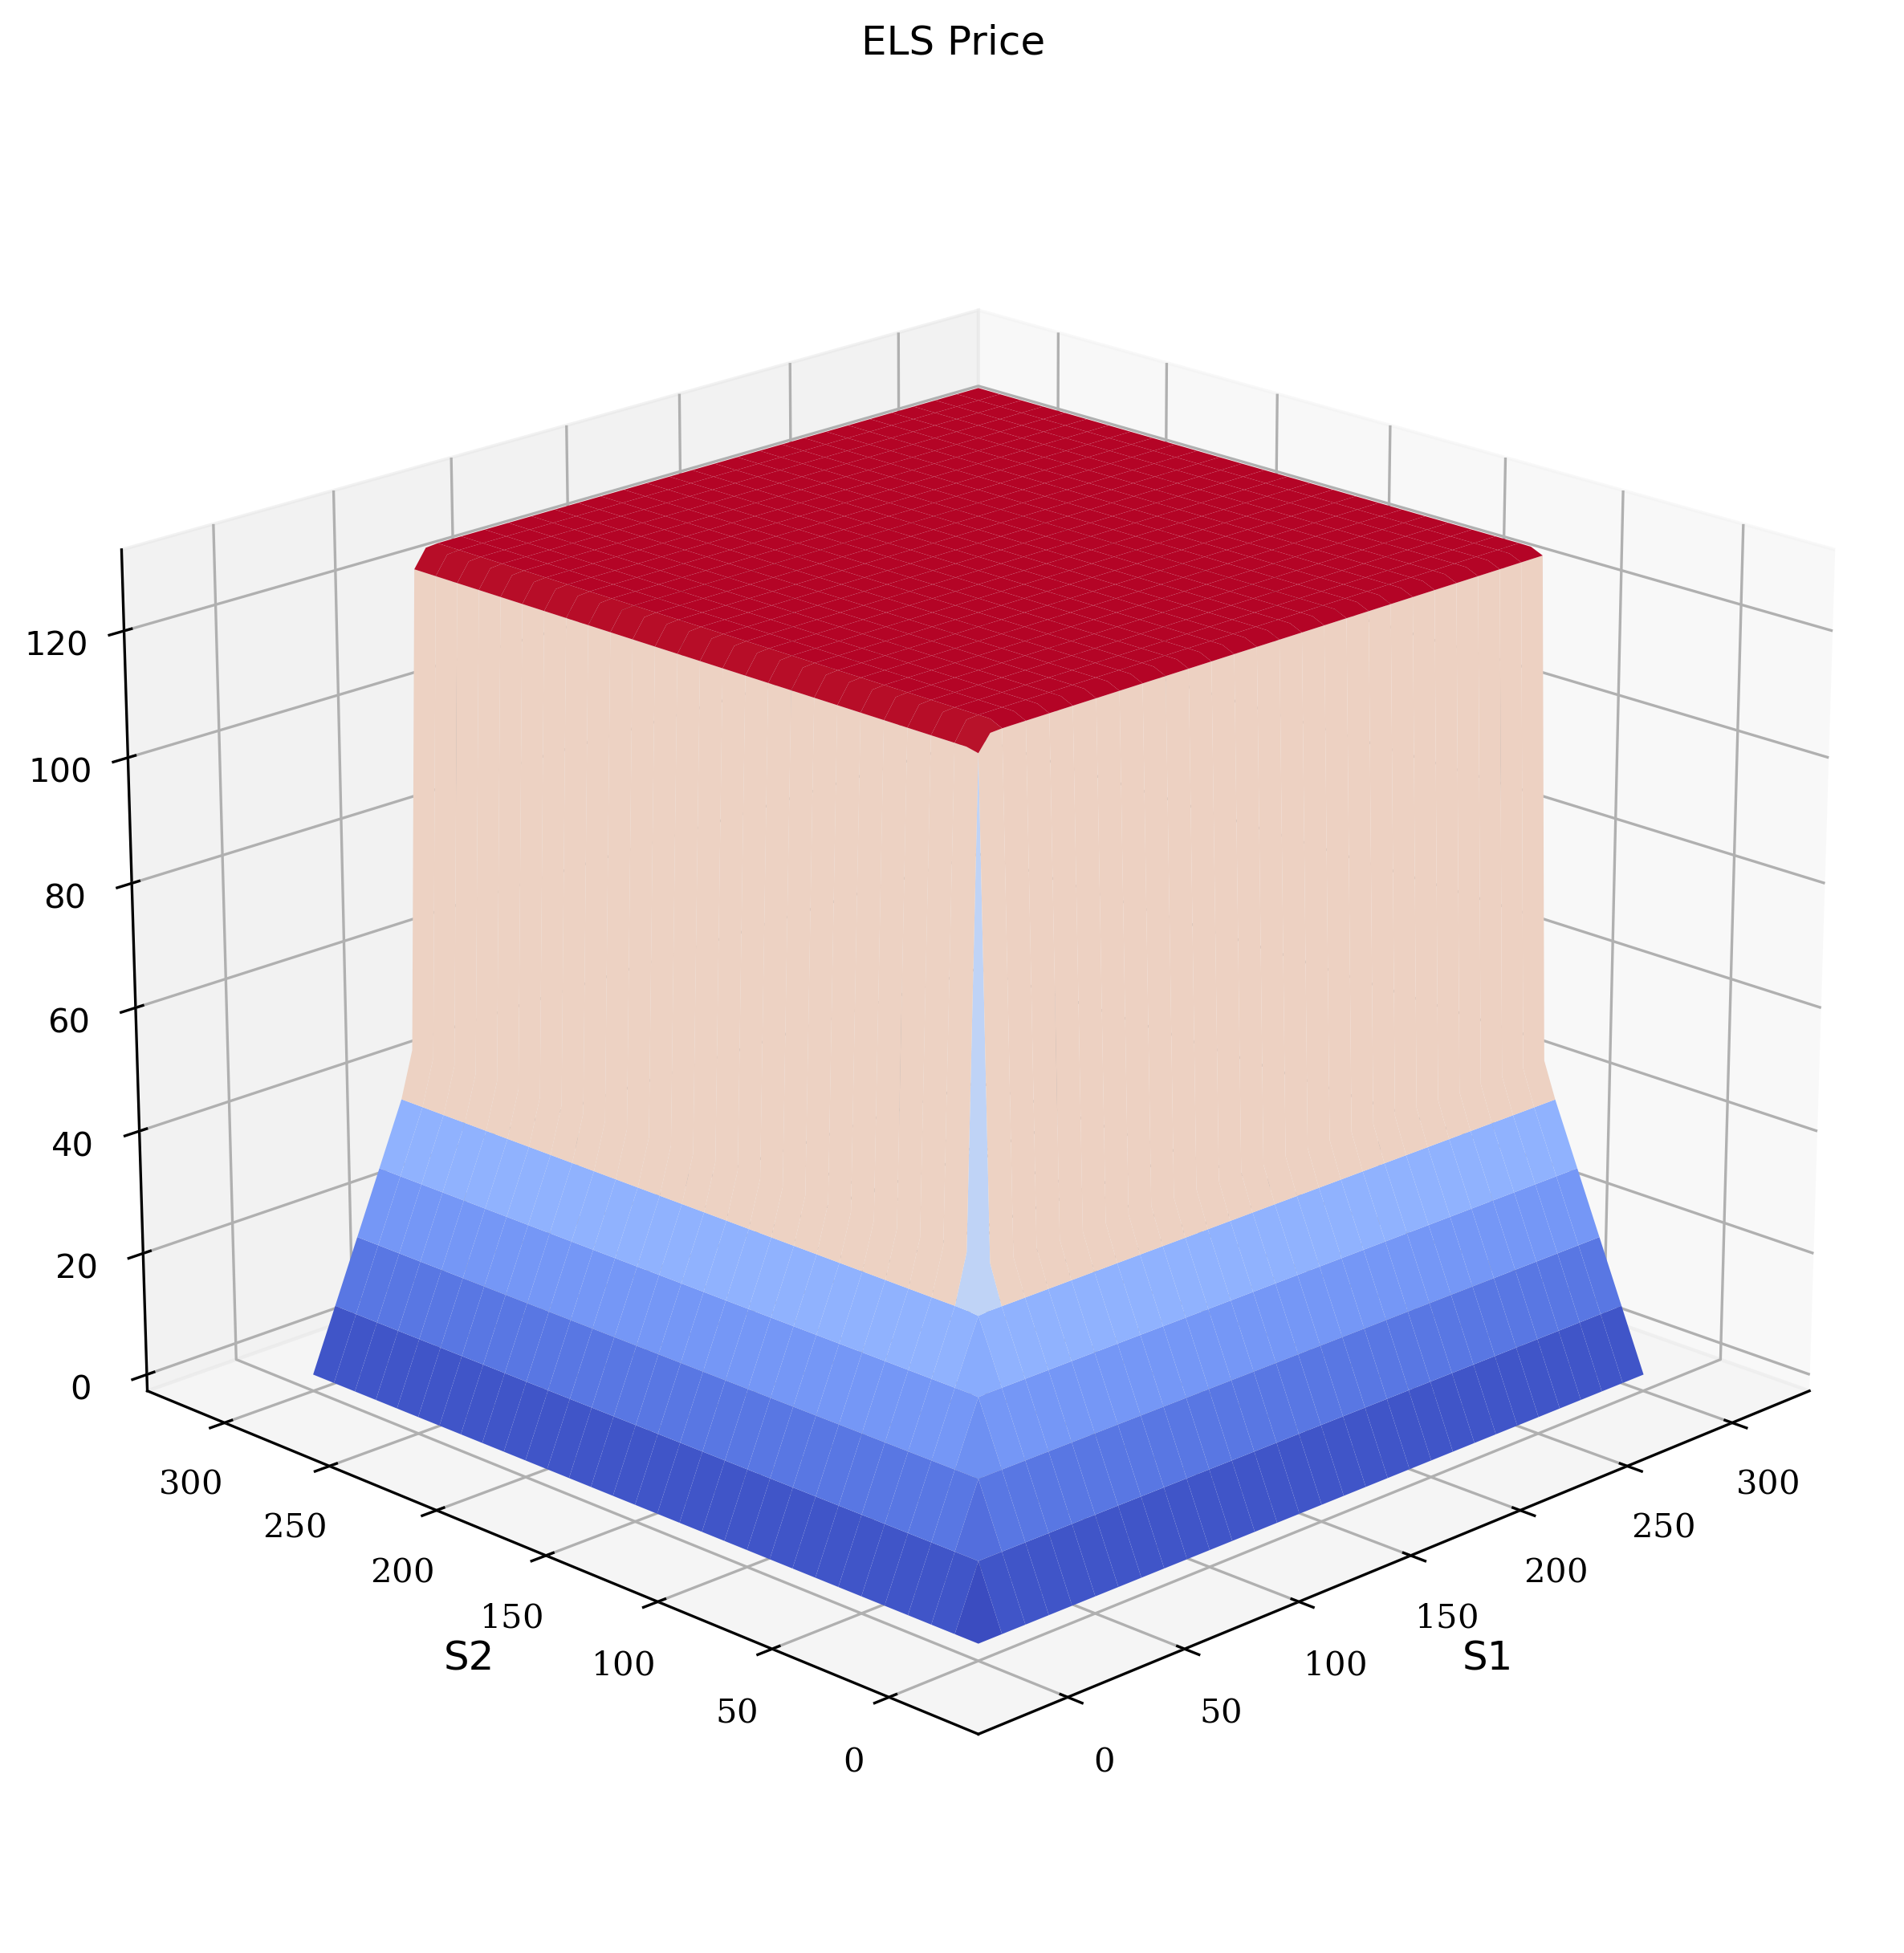

In [20]:
# No KI ELS
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(111, projection='3d')
surf0 = ax0.plot_surface(X, Y, us[0], cmap=plt.cm.coolwarm)
ax0.view_init(20, -135)
ax0.set_zlim3d(0.0, 130.0)
ax0.set_xlabel('S1', fontsize=12)
ax0.set_ylabel('S2', fontsize=12)
# ax0.set_zlabel('price')
ax0.set_xticks(np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]))
ax0.set_xticklabels(['$0$', '$50$', '$100$', '$150$', '$200$', '$250$', '$300$'])
ax0.set_yticks(np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]))
ax0.set_yticklabels(['$0$', '$50$', '$100$', '$150$', '$200$', '$250$', '$300$'])
# ax0.set_yticks(np.array([np.log10(1e-5), np.log10(1e-4), np.log10(1e-3), np.log10(1e-2)]), labels=['$10^{-5}$', '$10^{-4}$','$10^
ax0.set_title('ELS Price')
fig1.savefig('osm_u_zero.png')

Price=[[88.12818651]]


Text(0.5, 0.92, 'KI ELS t=0')

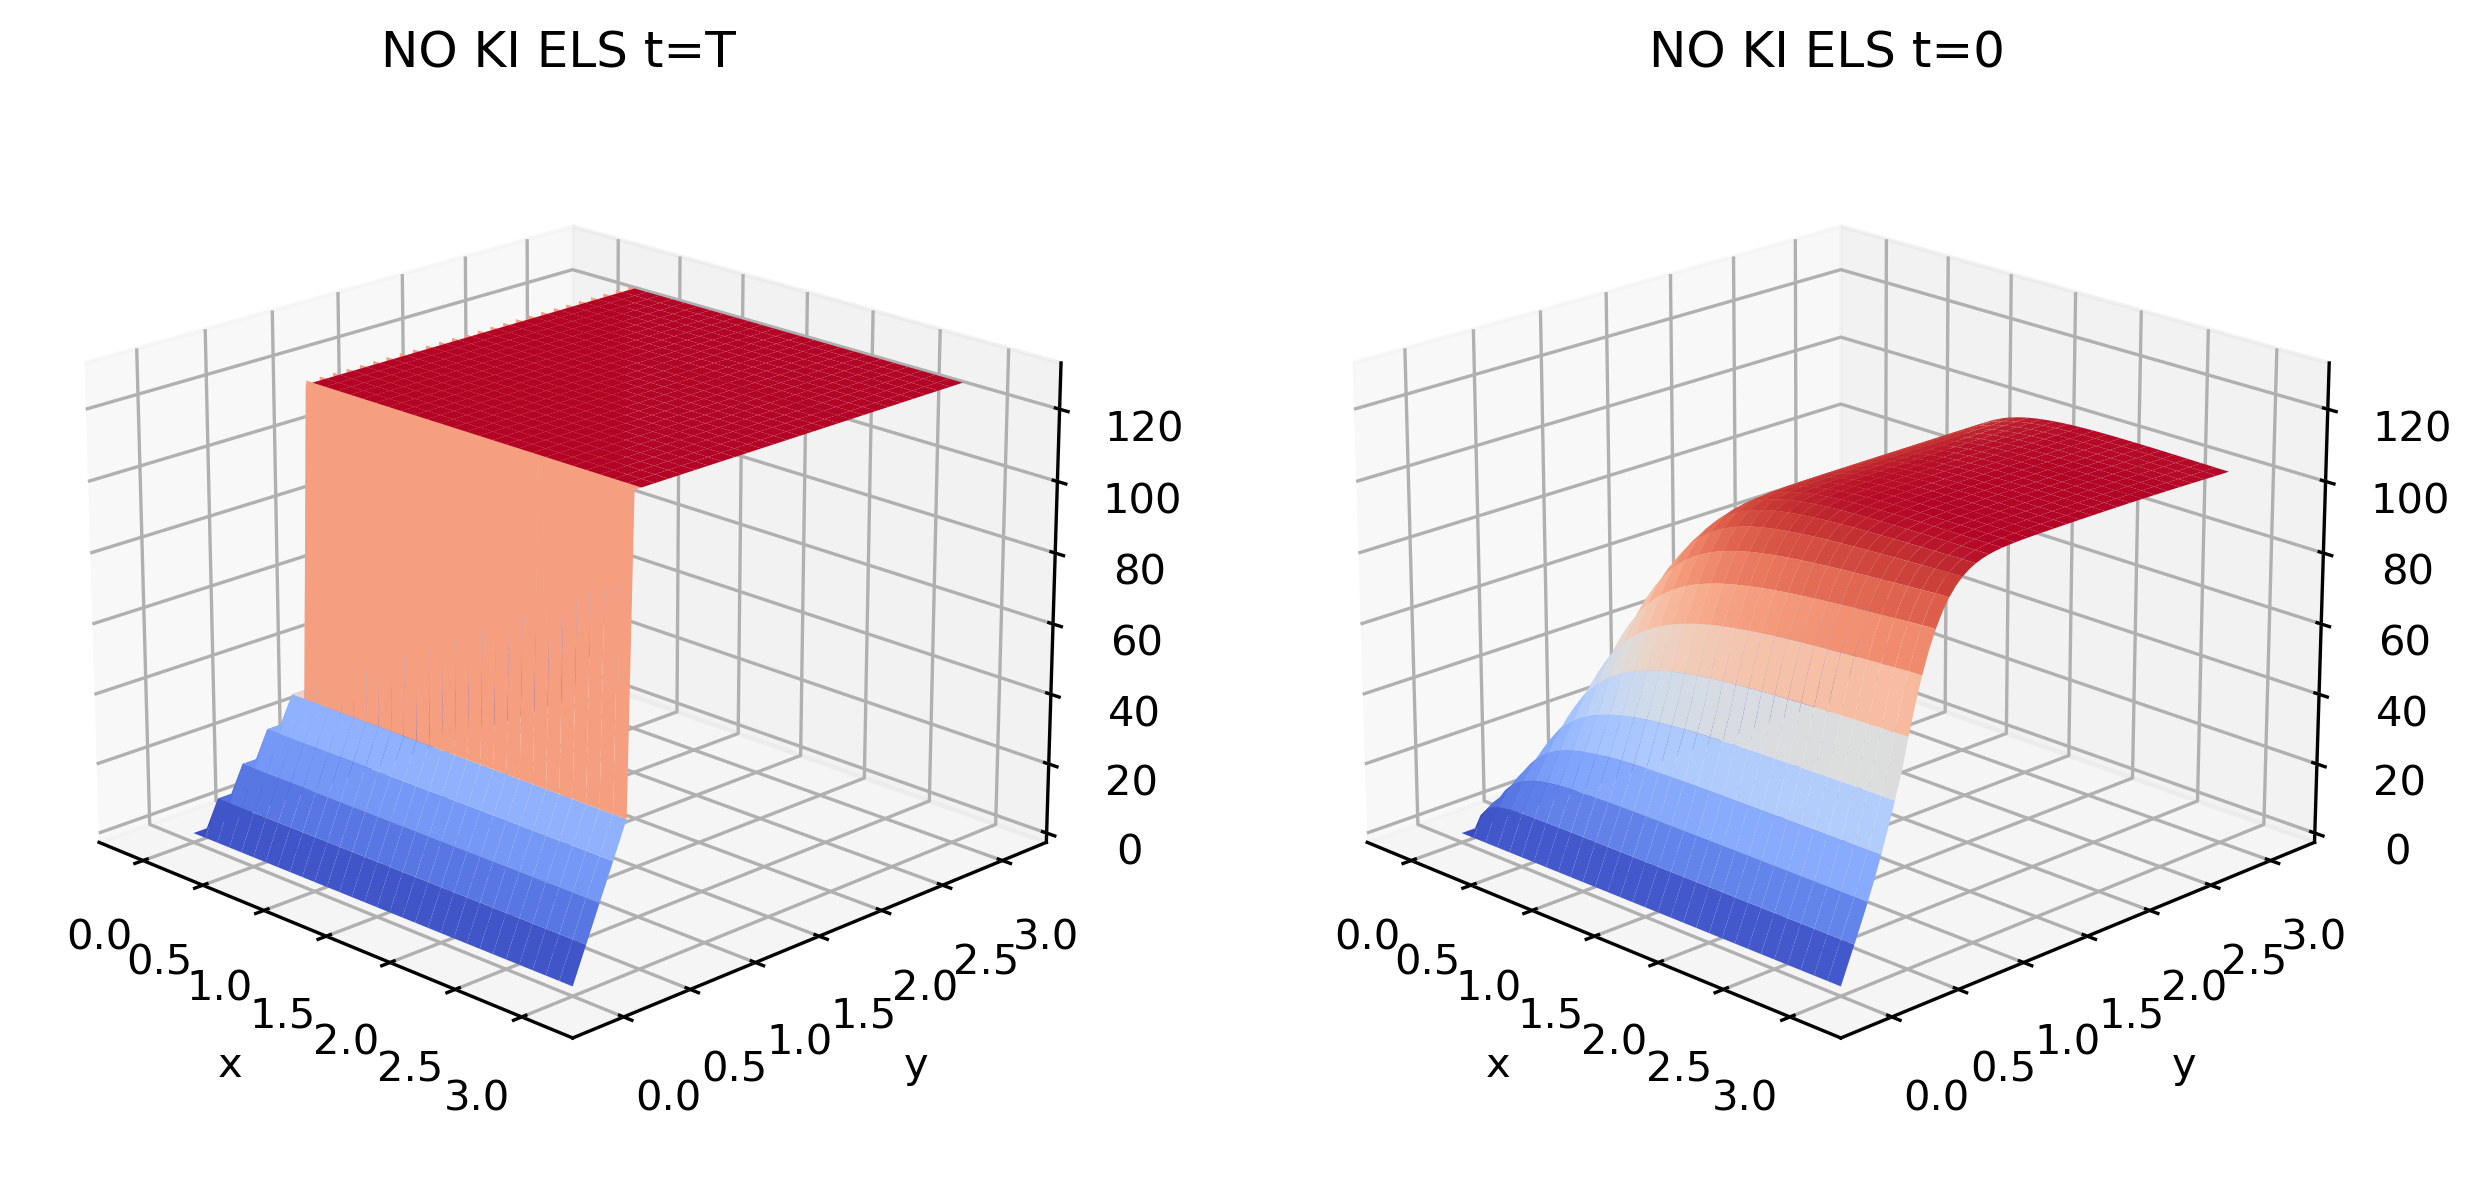

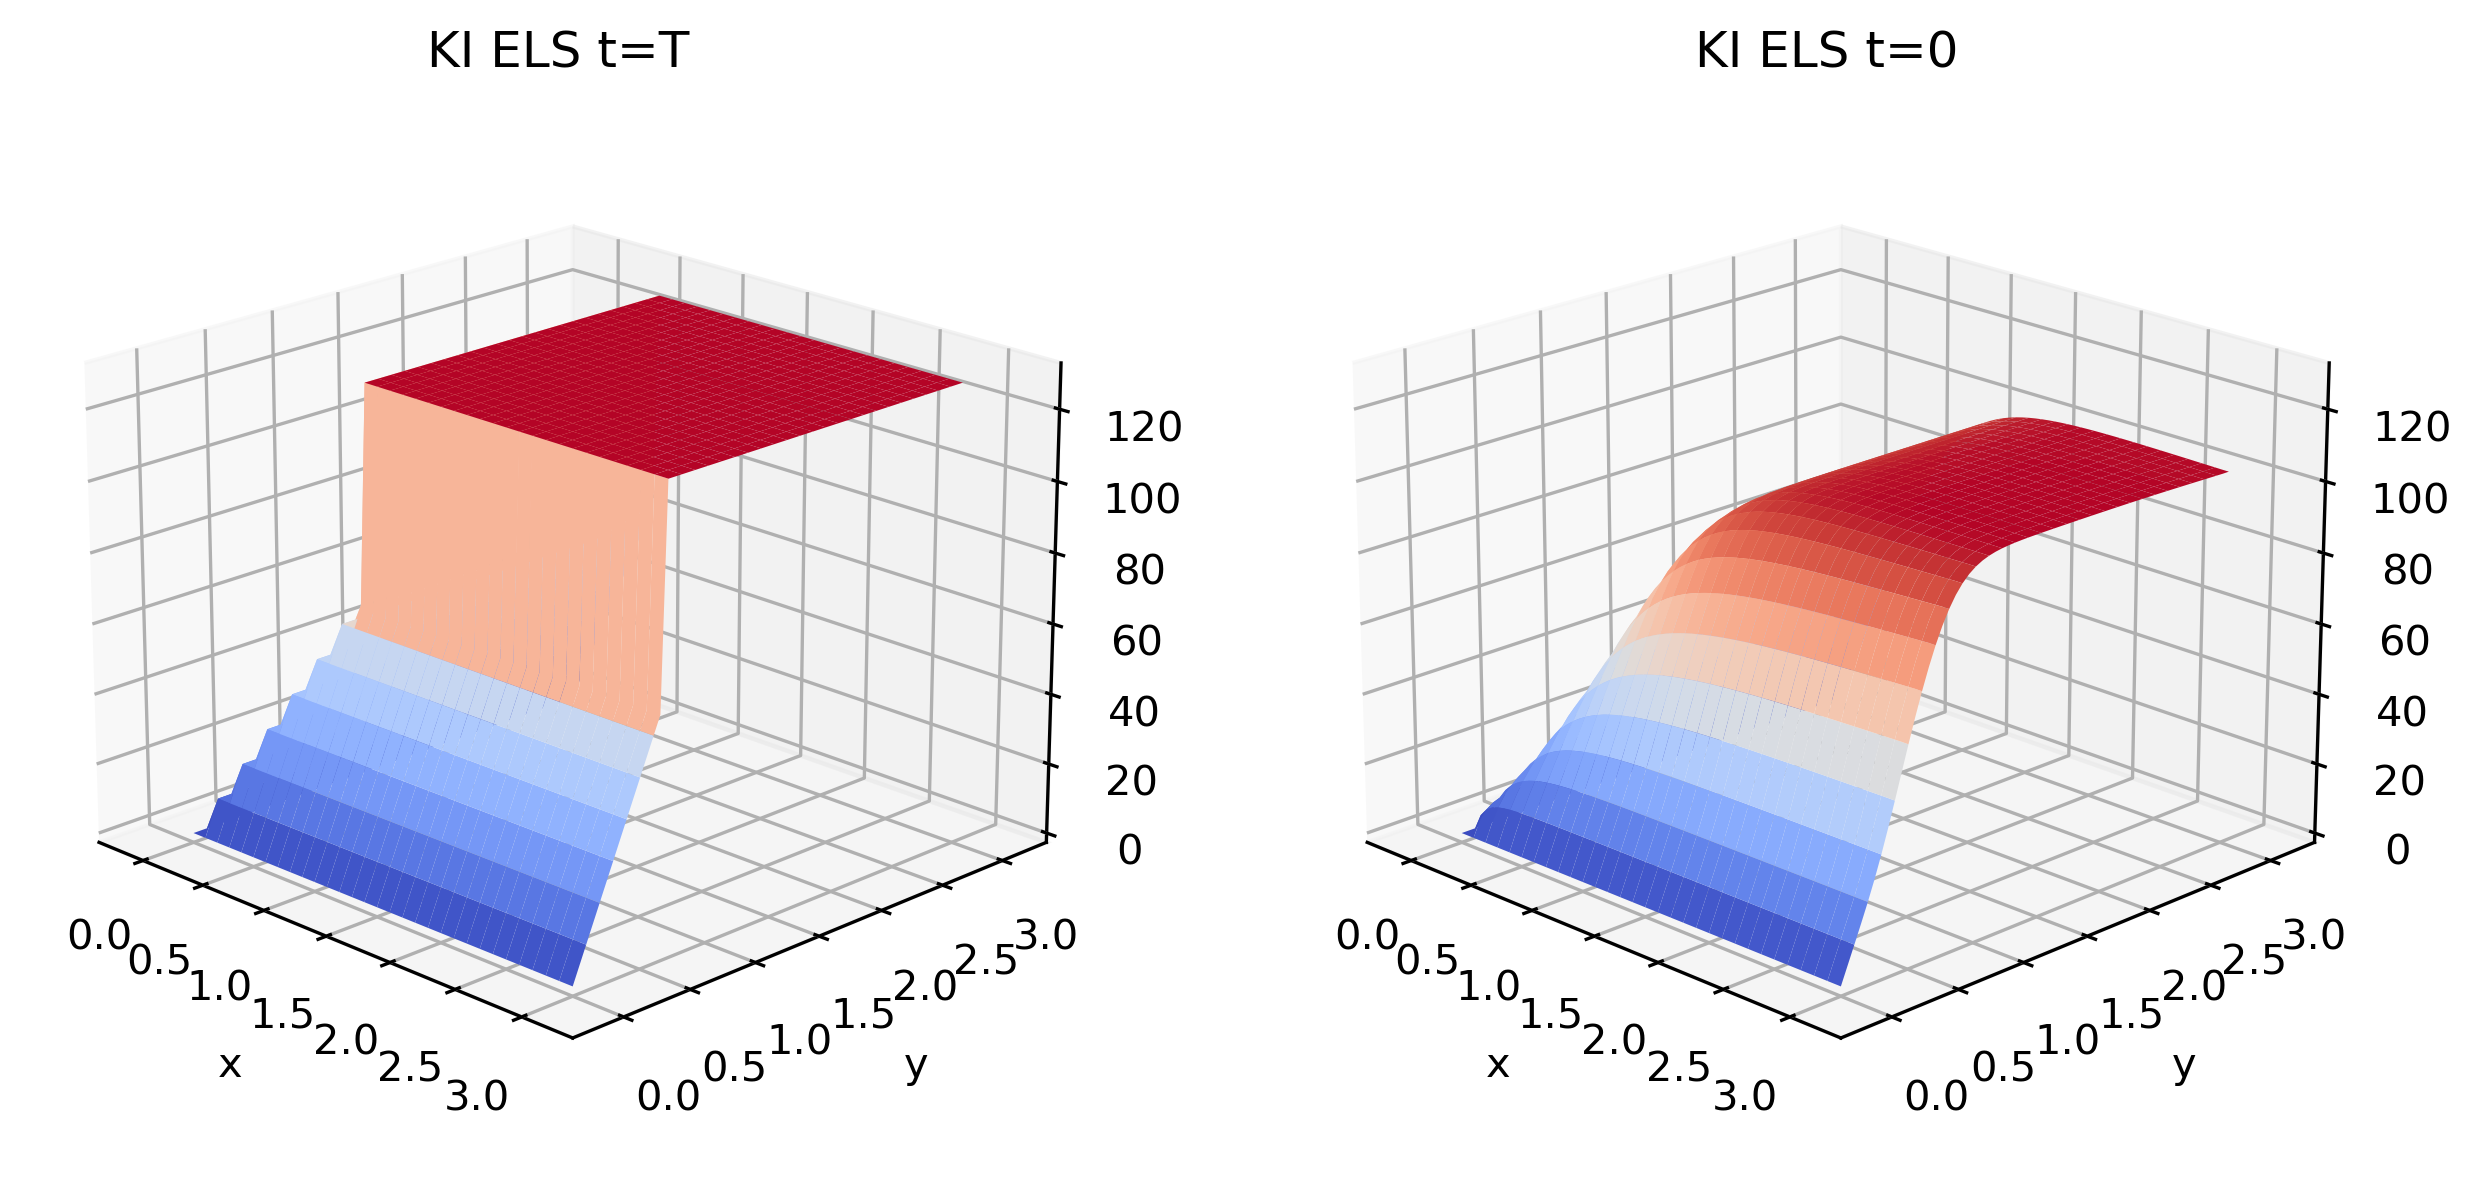

In [9]:
# No KI ELS
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')

ii = np.where(x==1)
jj = np.where(y==1)

print('Price={}'.format(u[ii,jj]))
# ax1.scatter(1.0, 1.0, u[ii,jj], s=100, c='k')

surf0 = ax0.plot_surface(X, Y, initial_u, cmap="coolwarm")
surf1 = ax1.plot_surface(X, Y, u, cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(20, -45)
ax1.view_init(20, -45)
ax0.set_zlim3d(0.0, 130.0)
ax1.set_zlim3d(0.0, 130.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('NO KI ELS t=T')
ax1.set_title('NO KI ELS t=0')

# KI ELS
fig2 = plt.figure(figsize=(10,10))
bx0 = fig2.add_subplot(121, projection='3d')
bx1 = fig2.add_subplot(122, projection='3d')
surfb0 = bx0.plot_surface(X, Y, initial_ku, cmap=plt.cm.coolwarm)
surfb1 = bx1.plot_surface(X, Y, ku, cmap=plt.cm.coolwarm)

# bx0.view_init(31, -134)
bx0.view_init(20, -45)
bx1.view_init(20, -45)
bx0.set_zlim3d(0.0, 130.0)
bx1.set_zlim3d(0.0, 130.0)
bx0.set_xlabel('x')
bx0.set_ylabel('y')
bx1.set_xlabel('x')
bx1.set_ylabel('y')
bx0.set_title('KI ELS t=T')
bx1.set_title('KI ELS t=0')

Text(0.5, 0.92, 'KI ELS t=0')

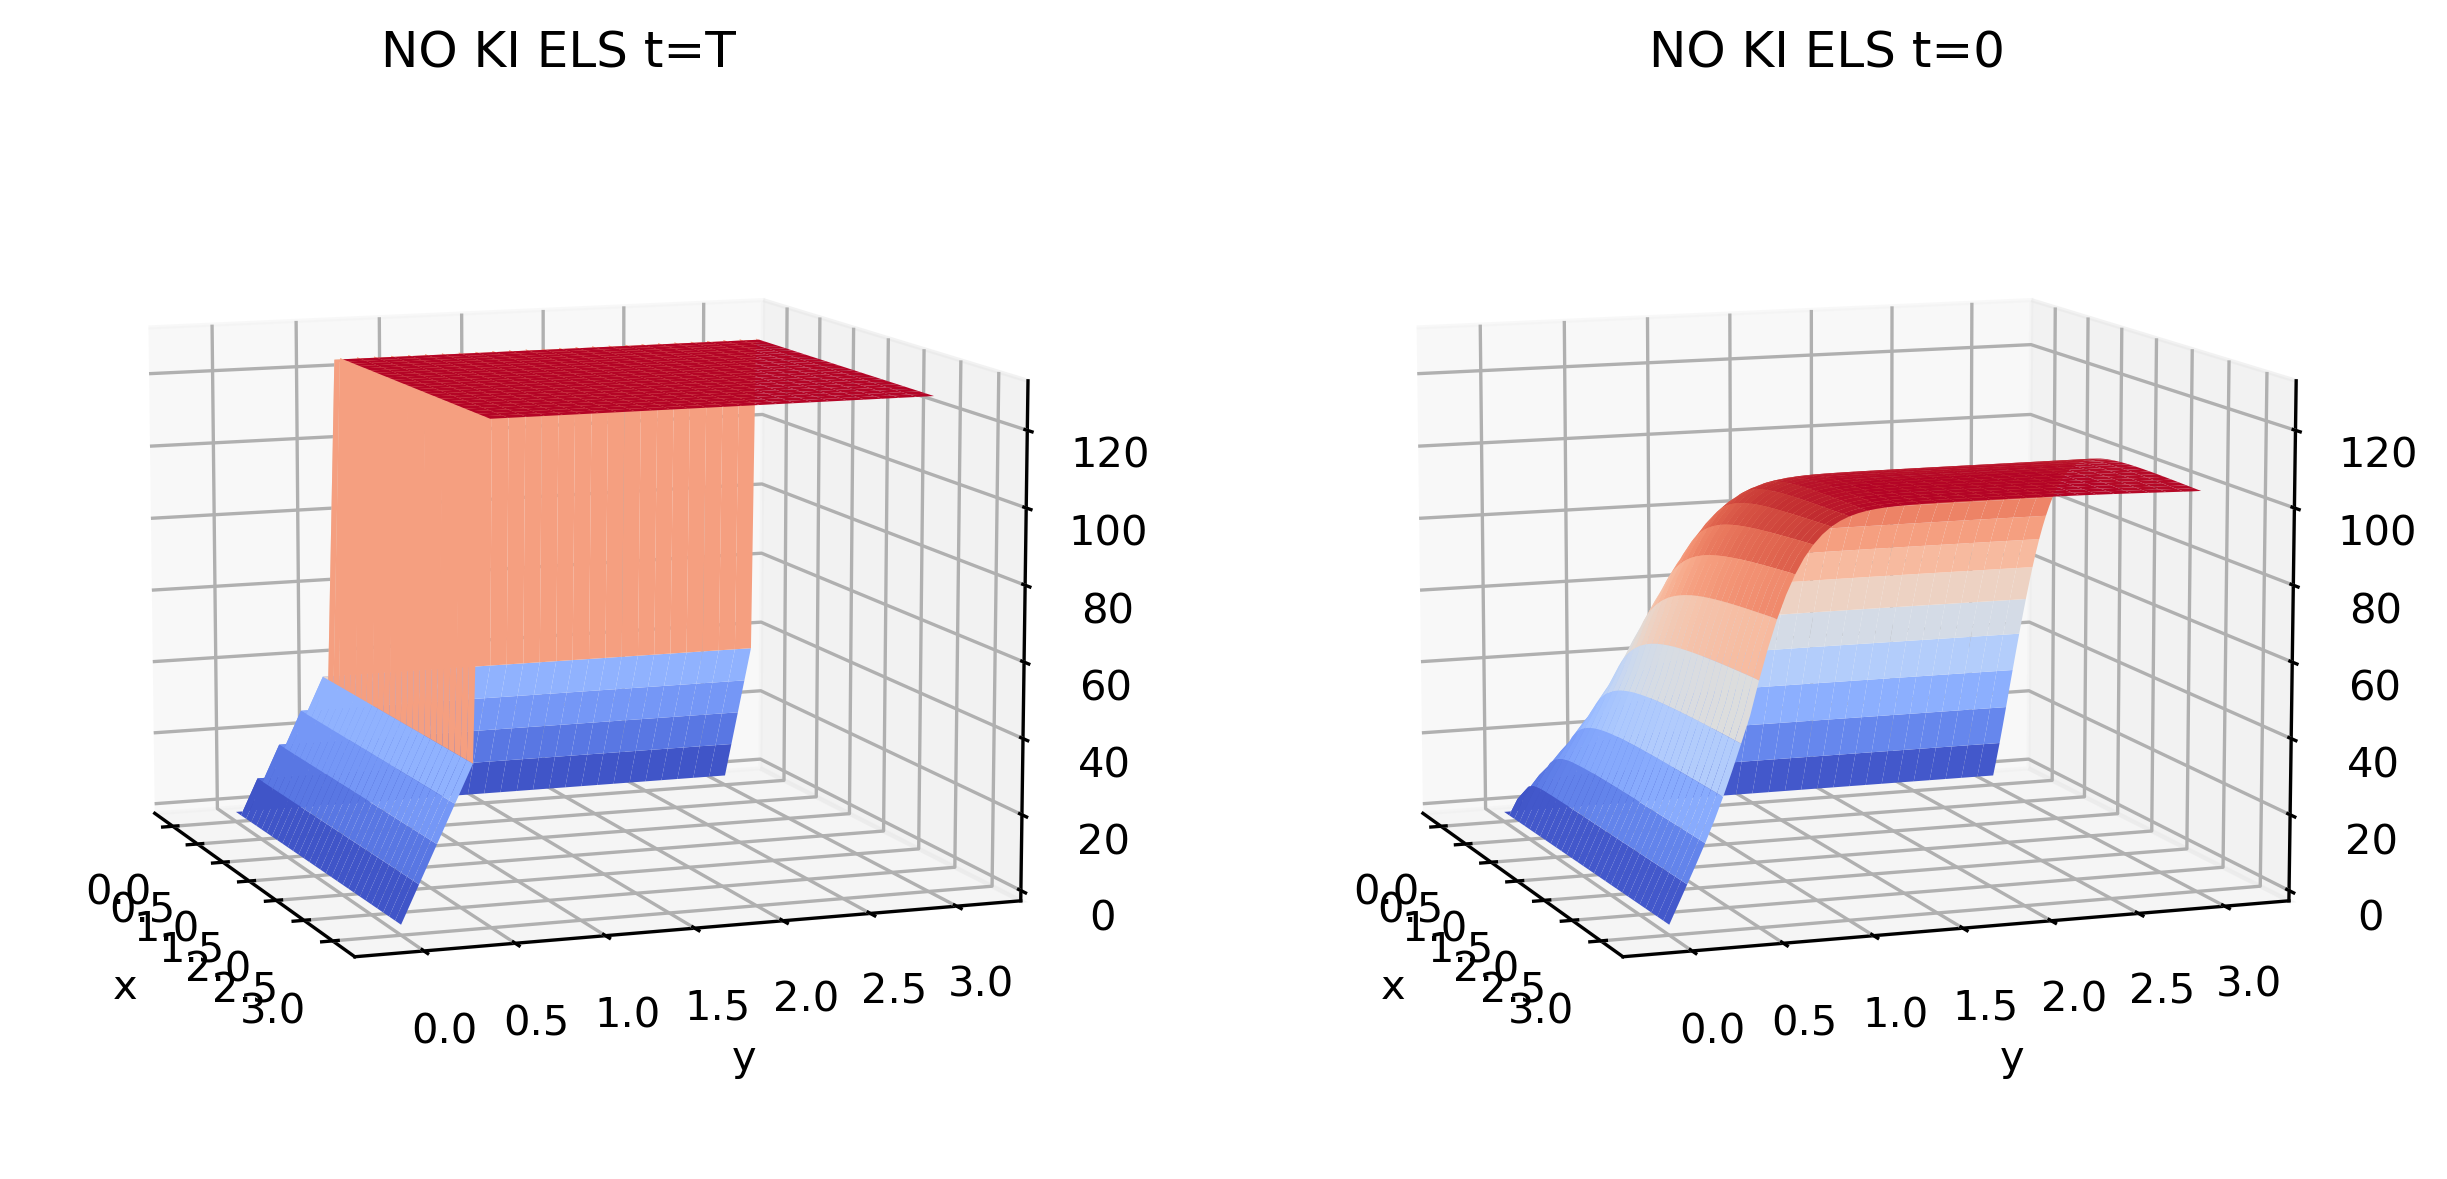

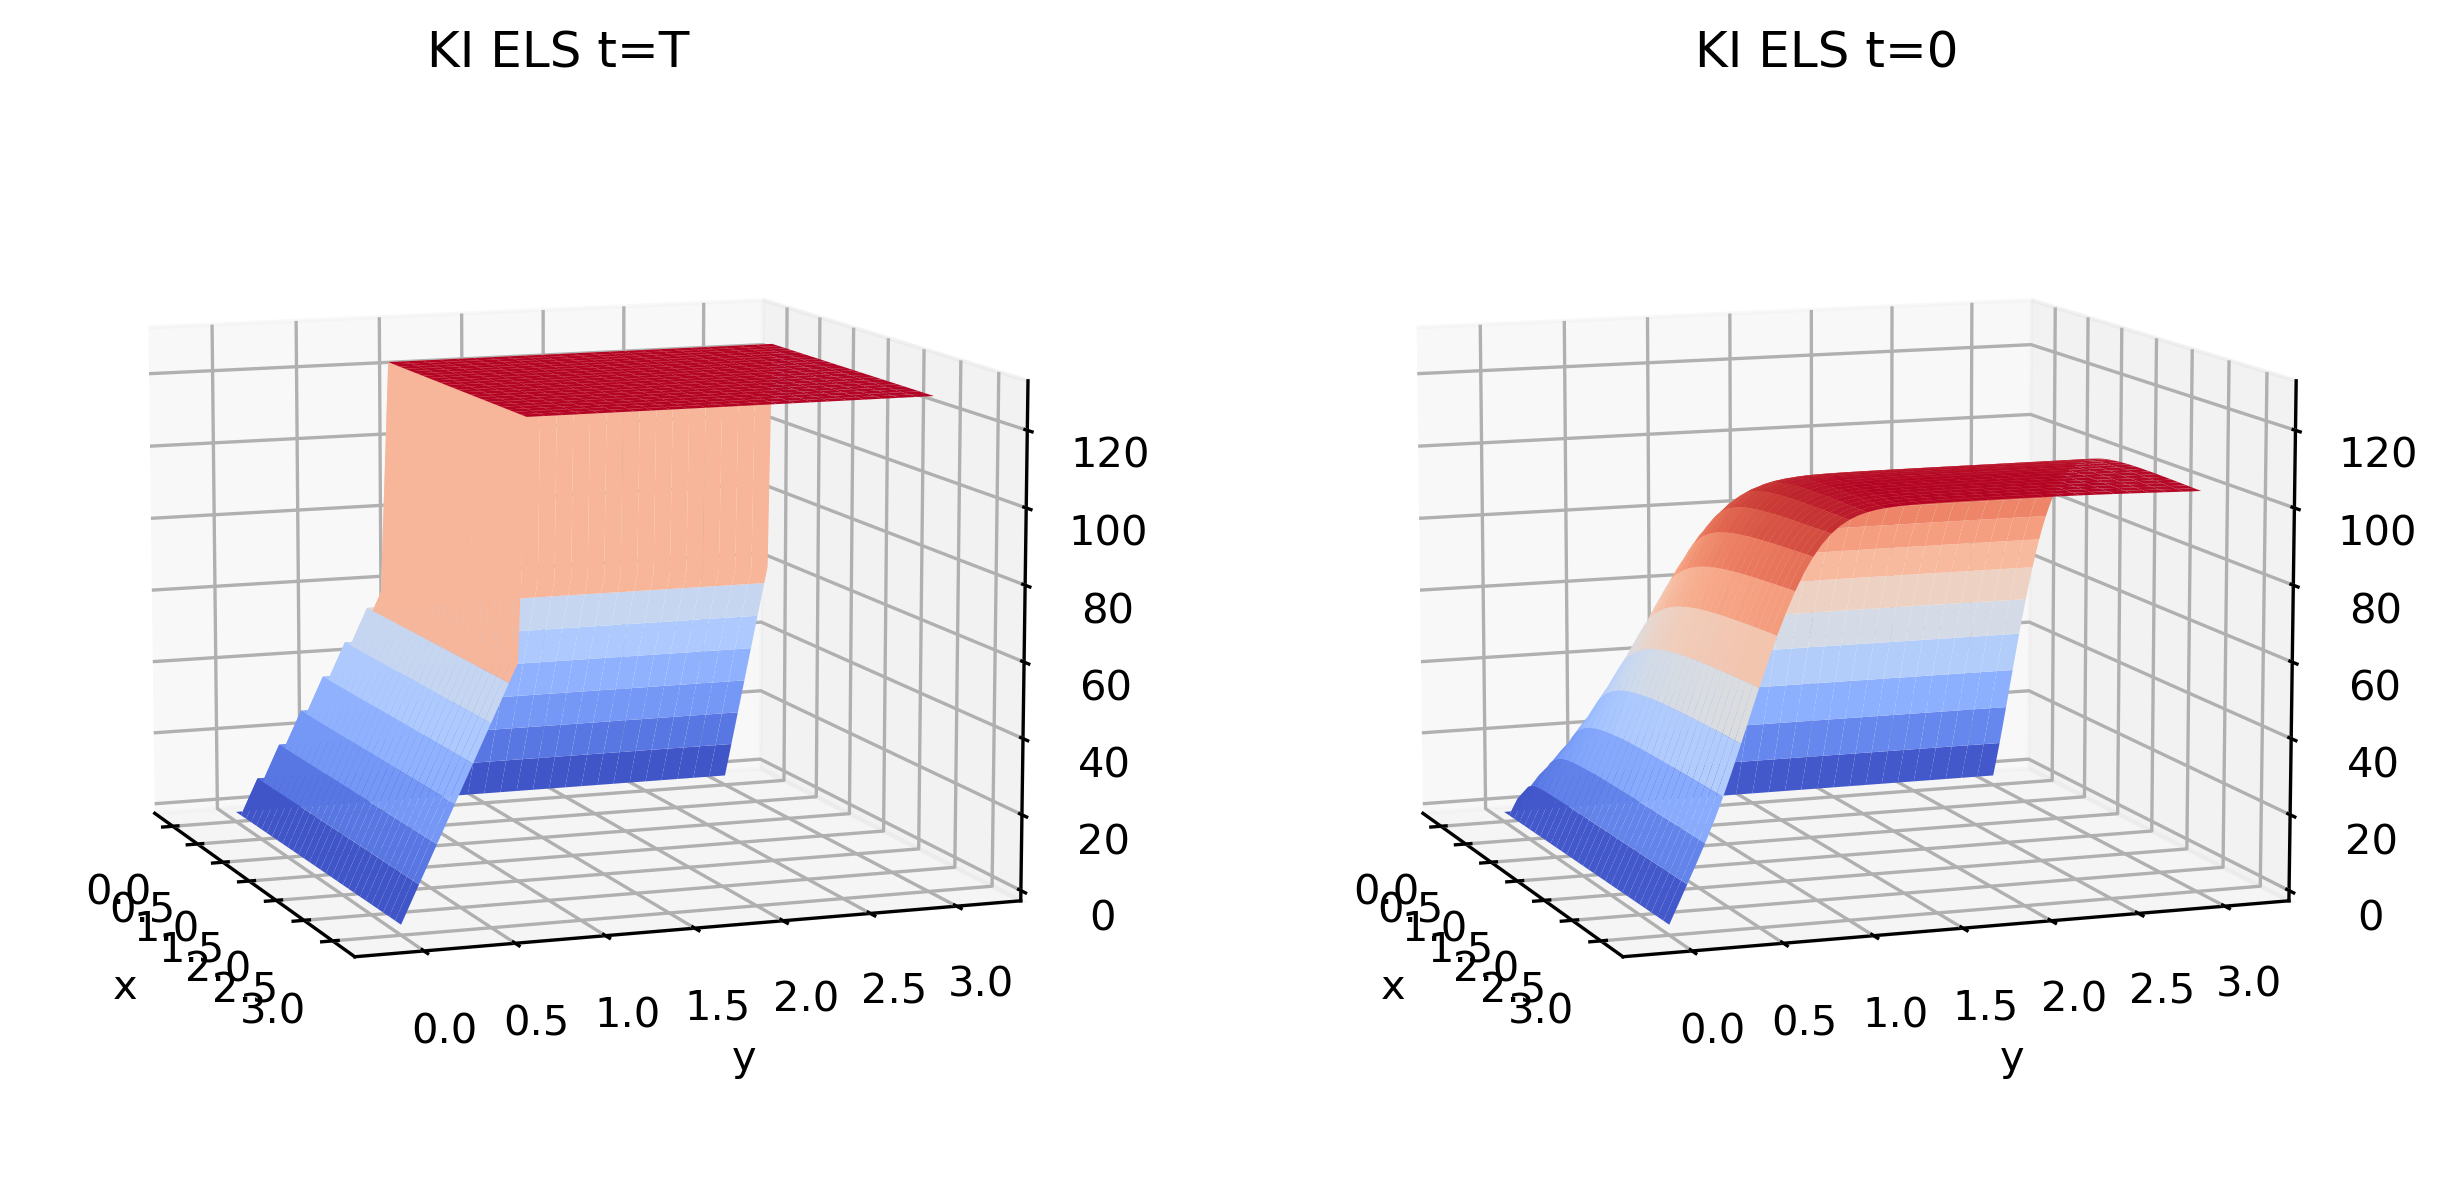

In [10]:
# No KI ELS
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')
surf0 = ax0.plot_surface(X, Y, initial_u, cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(X, Y, u, cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(10, -20)
ax1.view_init(10, -20)
ax0.set_zlim3d(0.0, 130.0)
ax1.set_zlim3d(0.0, 130.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('NO KI ELS t=T')
ax1.set_title('NO KI ELS t=0')

# KI ELS
fig2 = plt.figure(figsize=(10,10))
bx0 = fig2.add_subplot(121, projection='3d')
bx1 = fig2.add_subplot(122, projection='3d')
surfb0 = bx0.plot_surface(X, Y, initial_ku, cmap=plt.cm.coolwarm)
surfb1 = bx1.plot_surface(X, Y, ku, cmap=plt.cm.coolwarm)

# bx0.view_init(31, -134)
bx0.view_init(10, -20)
bx1.view_init(10, -20)
bx0.set_zlim3d(0.0, 130.0)
bx1.set_zlim3d(0.0, 130.0)
bx0.set_xlabel('x')
bx0.set_ylabel('y')
bx1.set_xlabel('x')
bx1.set_ylabel('y')
bx0.set_title('KI ELS t=T')
bx1.set_title('KI ELS t=0')

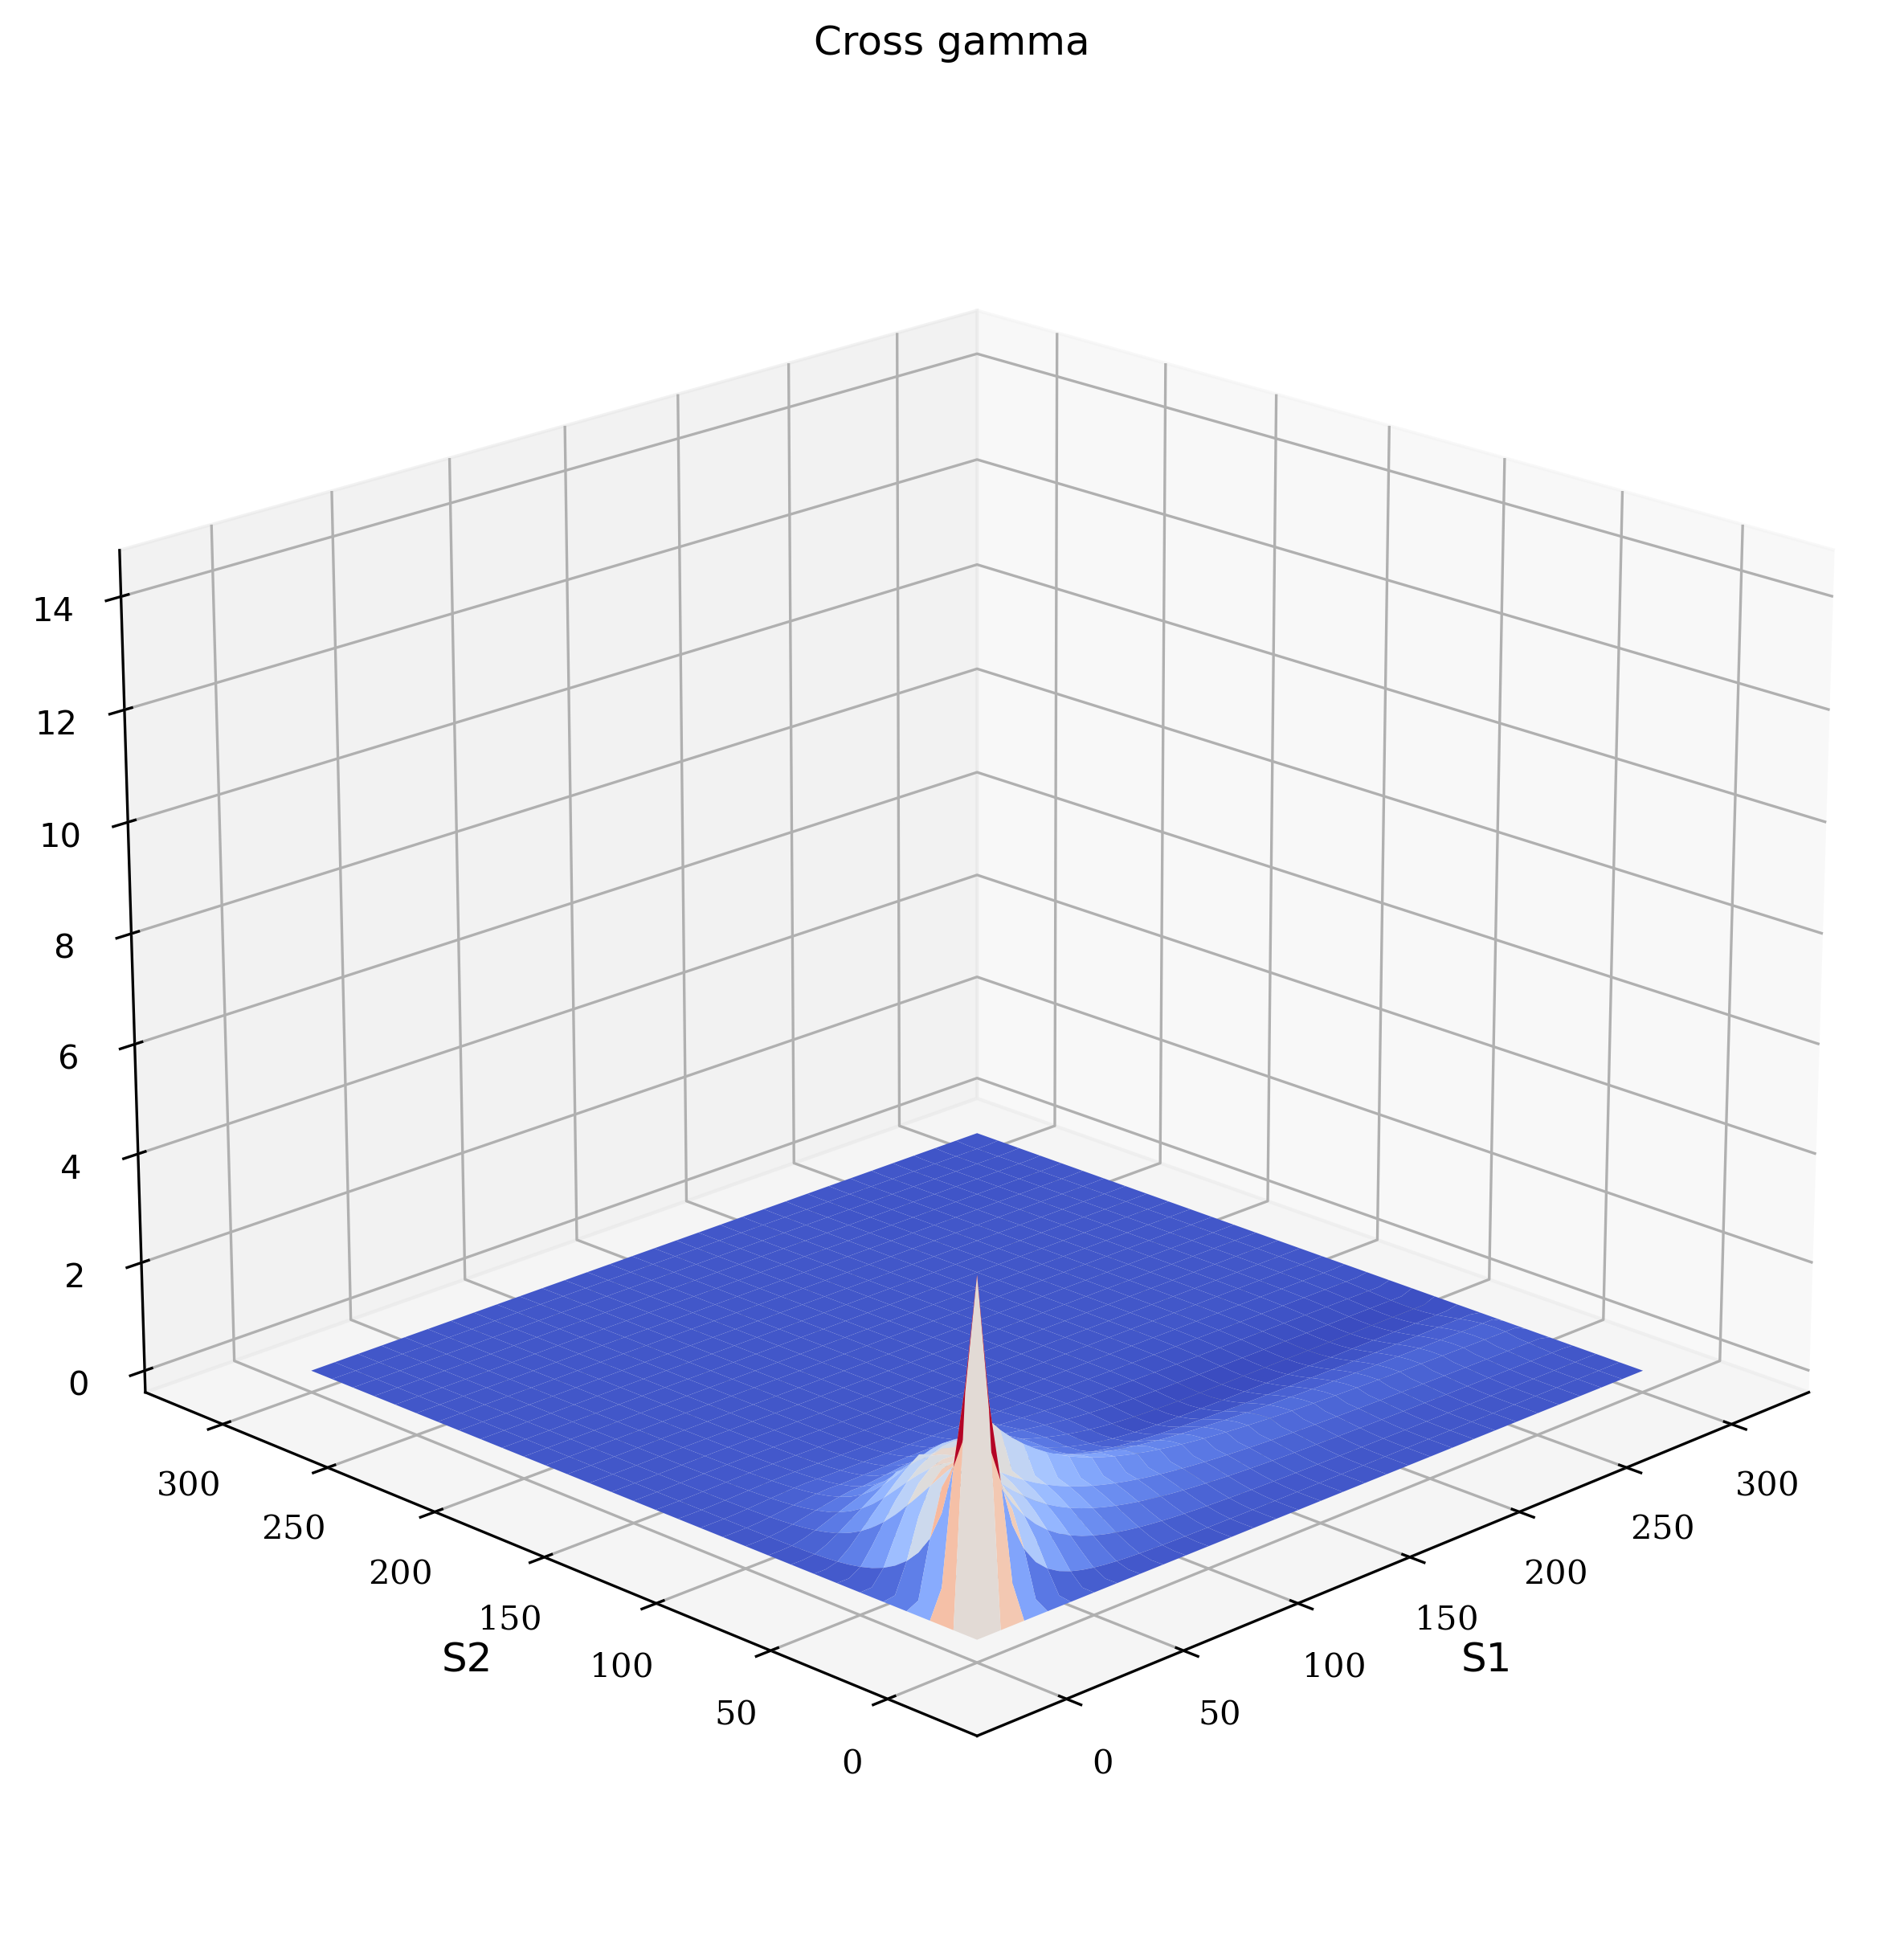

In [11]:
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(111, projection='3d')
# surf0 = ax0.plot_surface(X, Y, us[0], cmap=plt.cm.coolwarm)
surf0 = ax0.plot_surface(X, Y, crossgamma, cmap=plt.cm.coolwarm)
ax0.view_init(20, -135)
# ax0.set_zlim3d(0.0, 130.0)
ax0.set_xlabel('S1', fontsize=12)
ax0.set_ylabel('S2', fontsize=12)
# ax0.set_zlabel('price')
ax0.set_xticks(np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]))
ax0.set_xticklabels(['$0$', '$50$', '$100$', '$150$', '$200$', '$250$', '$300$'])
ax0.set_yticks(np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]))
ax0.set_yticklabels(['$0$', '$50$', '$100$', '$150$', '$200$', '$250$', '$300$'])
# ax0.set_yticks(np.array([np.log10(1e-5), np.log10(1e-4), np.log10(1e-3), np.log10(1e-2)]), labels=['$10^{-5}$', '$10^{-4}$','$10^
ax0.set_title('Cross gamma')
fig1.savefig('osm_u_crossgamma.png')

1.3452580184395848
1.8021398102076116
-0.005172796962388588
-0.005172796962388588
(array([2]), array([0]))
(array([59, 60]), array([58, 58]))
(array([10, 10]), array([59, 60]))
(array([58, 58]), array([59, 60]))


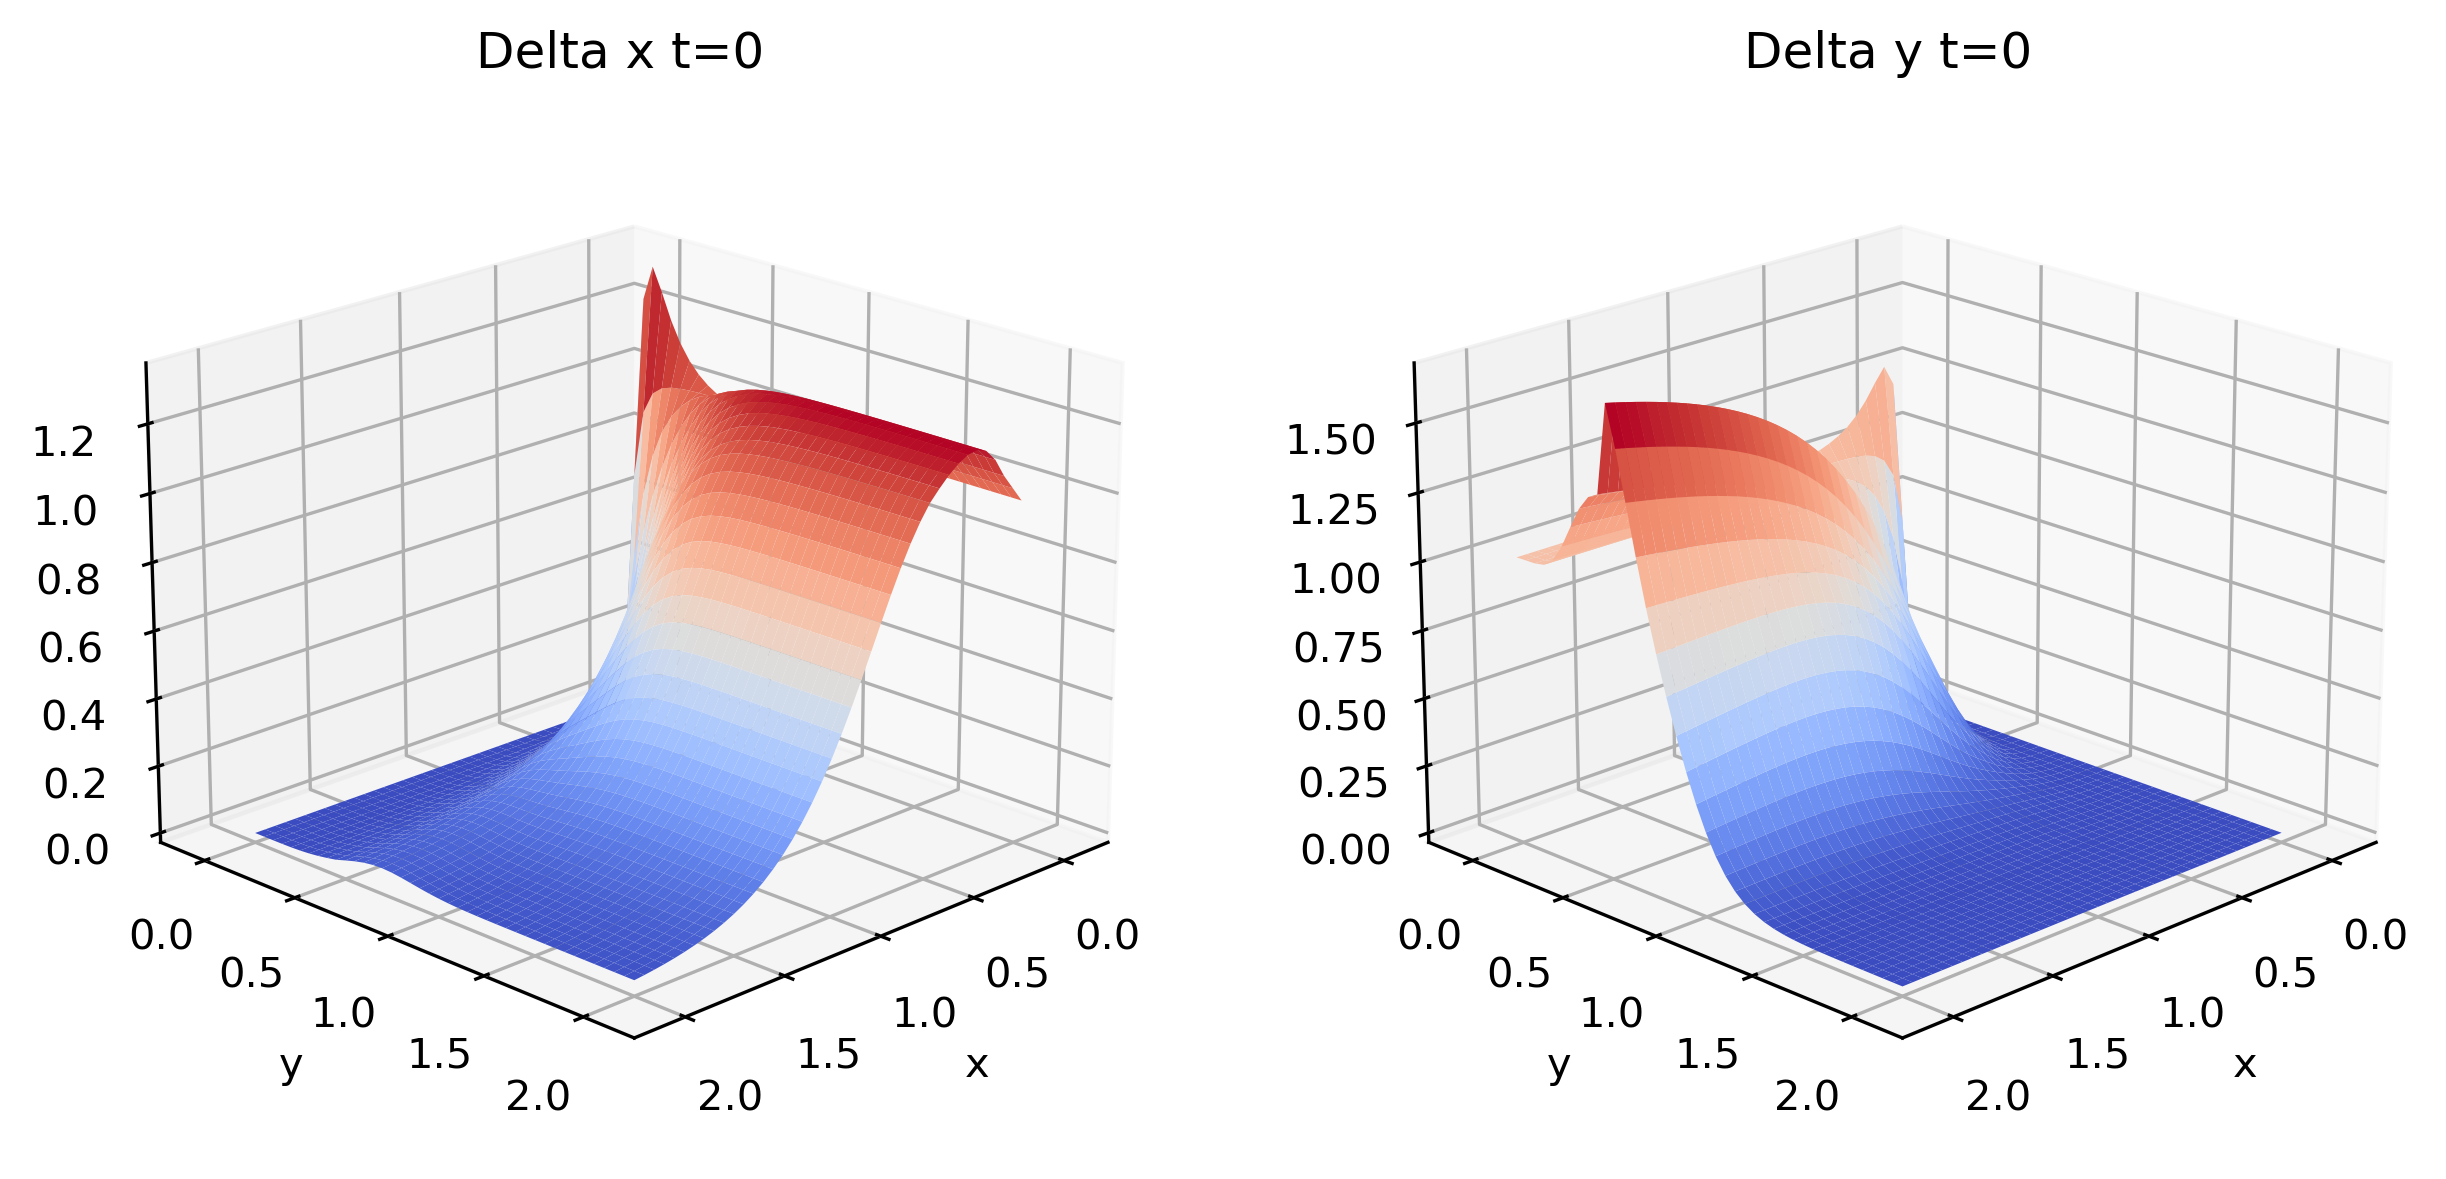

In [12]:
# No KI ELS

# XX,YY = np.meshgrid(x[5:],y[5:])
XX,YY = np.meshgrid(x[:41],y[:41])
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')
# surf0 = ax0.plot_surface(XX, YY, deltax[5:,5:], cmap=plt.cm.coolwarm)
# surf1 = ax1.plot_surface(XX, YY, deltay[5:,5:], cmap=plt.cm.coolwarm)
surf0 = ax0.plot_surface(XX, YY, kdeltaxs[-1][:41,:41], cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(XX, YY, kdeltays[-1][:41,:41], cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(20, 45)
ax1.view_init(20, 45)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# ax0.set_zlim3d(0.0, 120.0)
# ax1.set_zlim3d(0.0, 120.0)
ax0.set_title('Delta x t=0')
ax1.set_title('Delta y t=0')

print(np.max(kdeltaxs[-1][:,:]))
print(np.max(kdeltays[-1][:,:]))
print(np.min(kdeltaxs[-1][:,:]))
print(np.min(kdeltaxs[-1][:,:]))

print(np.where(kdeltaxs[-1][:,:]==np.max(kdeltaxs[-1][:,:])))
print(np.where(kdeltaxs[-1][:,:]==np.min(kdeltaxs[-1][:,:])))
print(np.where(kdeltays[-1][:,:]==np.max(kdeltays[-1][:,:])))
print(np.where(kdeltays[-1][:,:]==np.min(kdeltays[-1][:,:])))

Text(0.5, 0.92, 'Gamma y t=0')

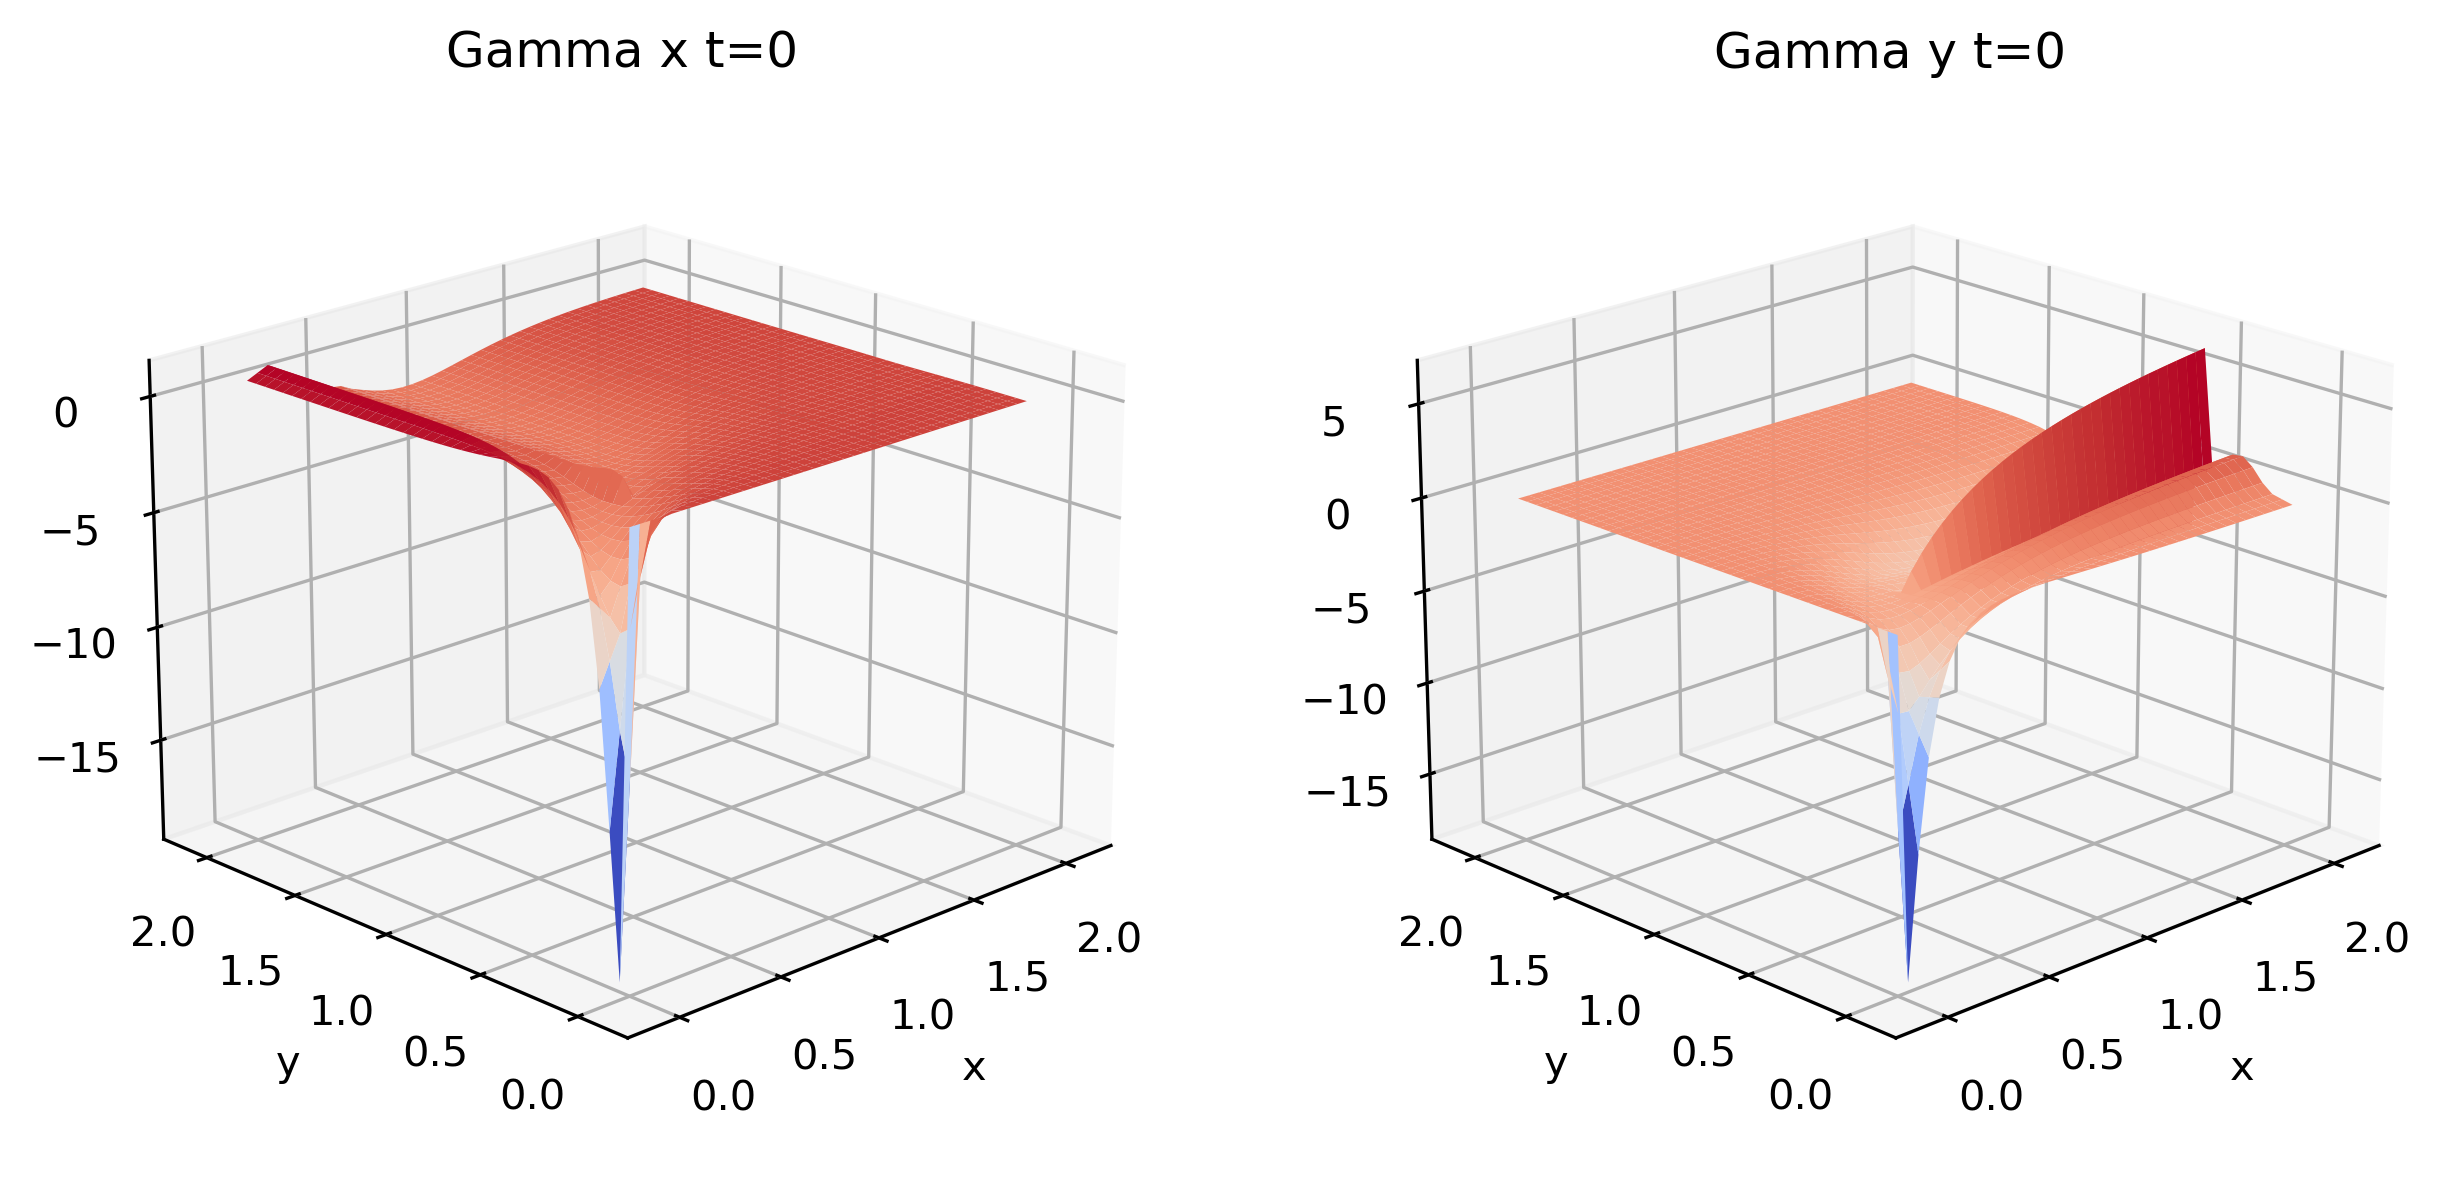

In [13]:
# No KI ELS
# X,Y = np.meshgrid(x[5:],y[5:])
X,Y = np.meshgrid(x[:41],y[:41])
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')
# surf0 = ax0.plot_surface(X, Y, gammax[5:,5:], cmap=plt.cm.coolwarm)
# surf1 = ax1.plot_surface(X, Y, gammay[5:,5:], cmap=plt.cm.coolwarm)
surf0 = ax0.plot_surface(X, Y, gammax[:41,:41], cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(X, Y, gammay[:41,:41], cmap=plt.cm.coolwarm)

ax0.view_init(20, -134)
ax1.view_init(20, -134)
# ax0.view_init(10, 65)
# ax1.view_init(10, 20)
# ax0.set_zlim3d(0.0, 120.0)
# ax1.set_zlim3d(0.0, 120.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('Gamma x t=0')
ax1.set_title('Gamma y t=0')


Text(0.5, 0.92, 'Theta t=0')

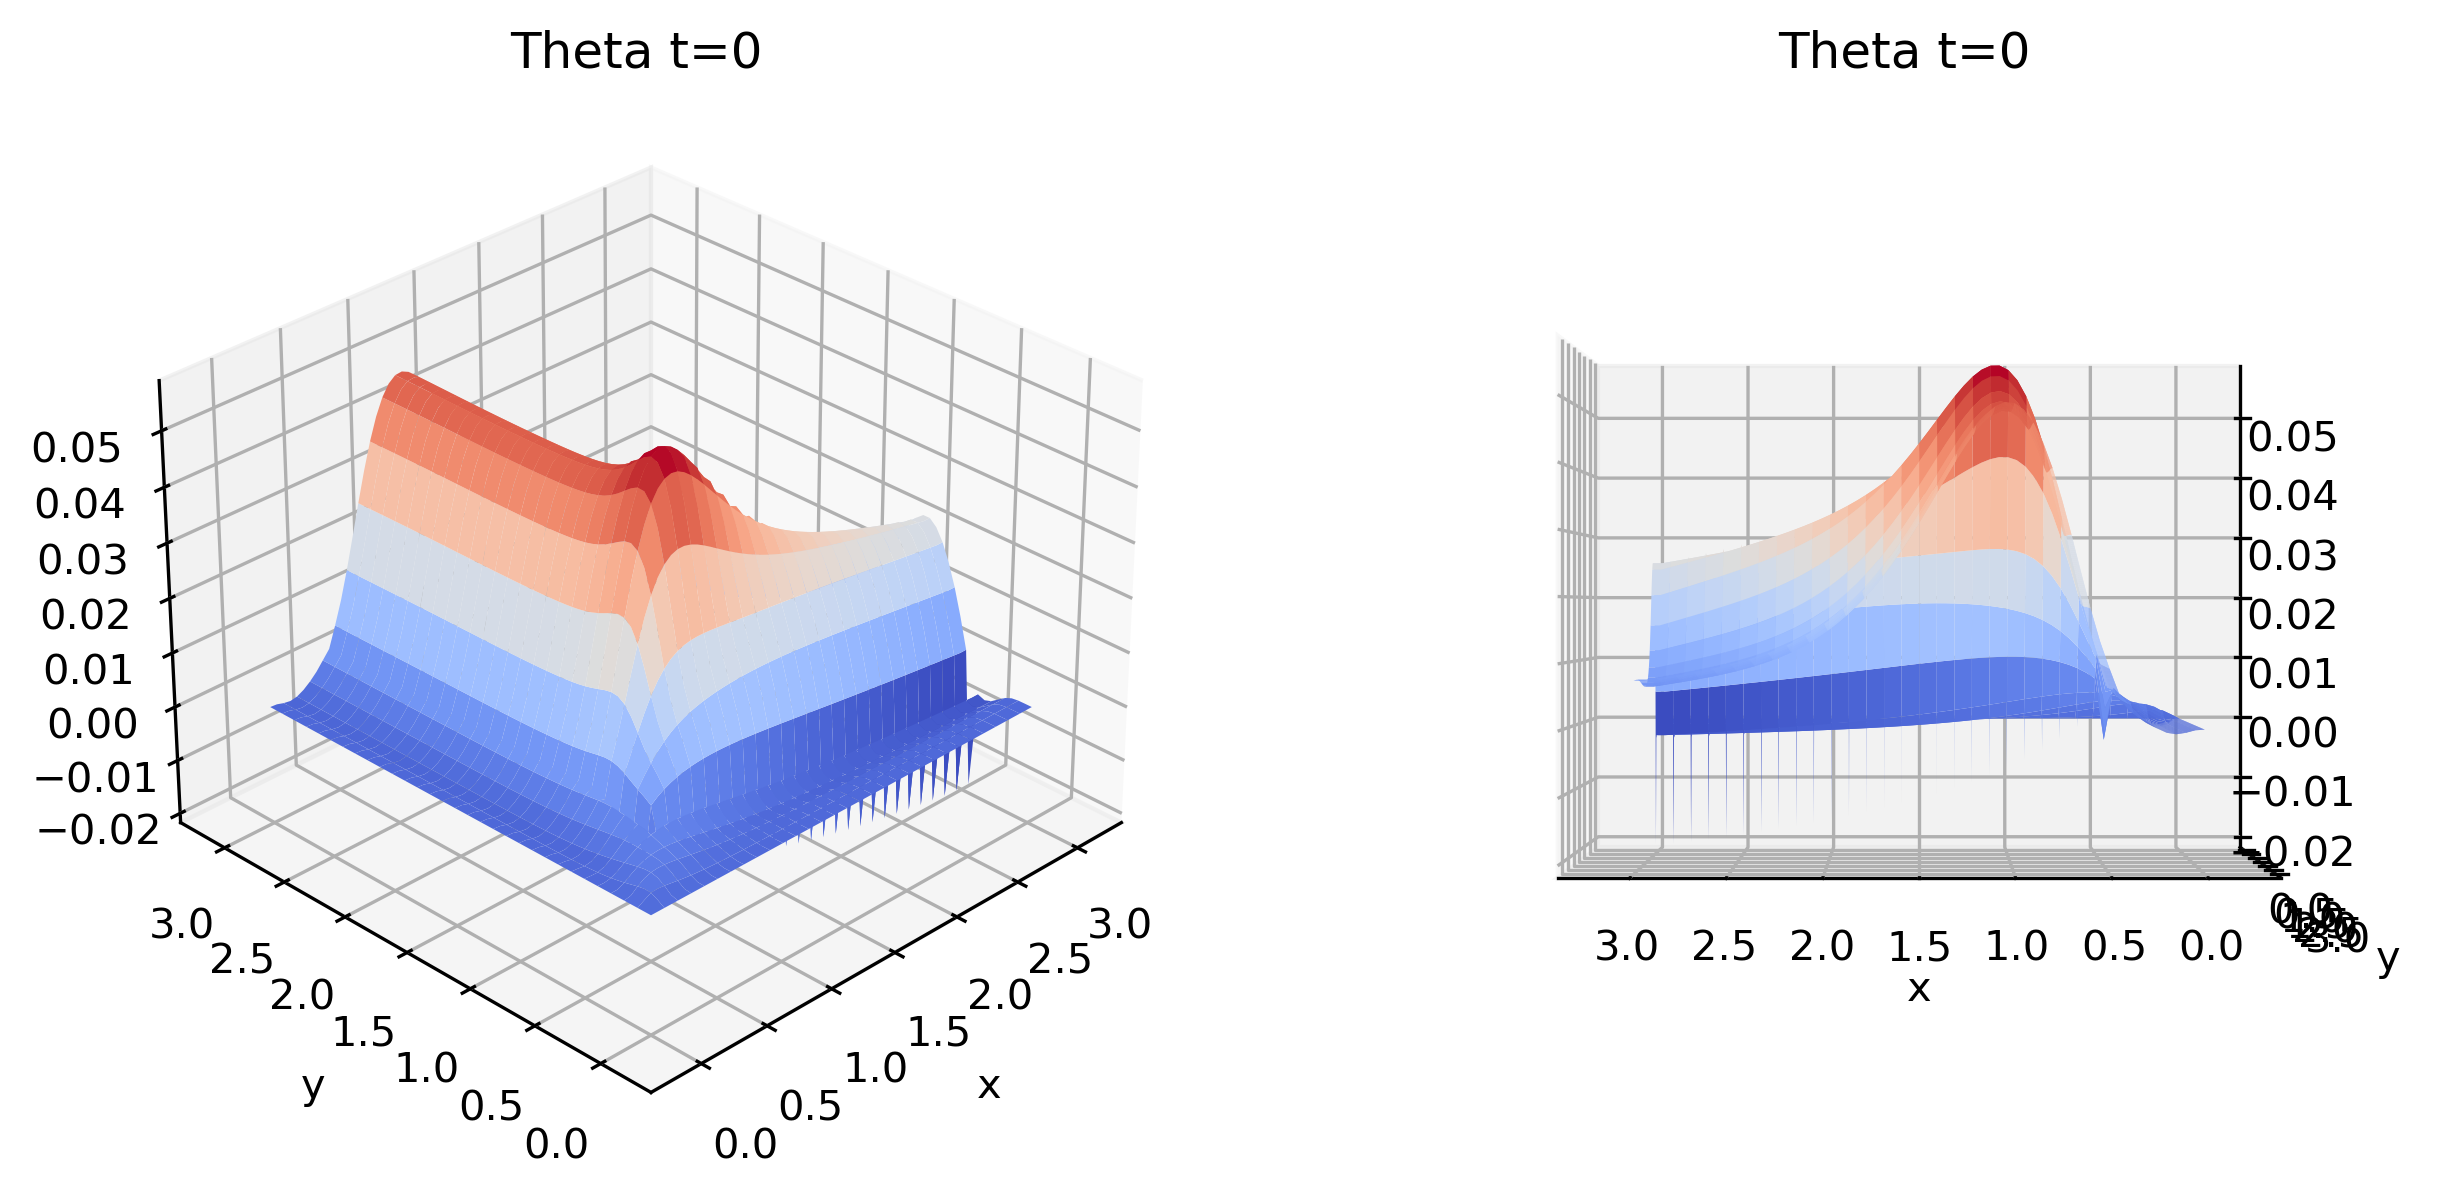

In [14]:
# No KI ELS
# X,Y = np.meshgrid(x[5:],y[5:])
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')
# surf0 = ax0.plot_surface(X, Y, theta[5:,5:], cmap=plt.cm.coolwarm)
# surf1 = ax1.plot_surface(X, Y, theta[5:,5:], cmap=plt.cm.coolwarm)
surf0 = ax0.plot_surface(X, Y, theta, cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(X, Y, theta, cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(30, -135)
# ax1.view_init(10, -20)
ax1.view_init(0, -270)
# ax0.set_zlim3d(0.0, 120.0)
# ax1.set_zlim3d(0.0, 120.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('Theta t=0')
ax1.set_title('Theta t=0')


Text(0.5, 0.92, 'Theta t=0')

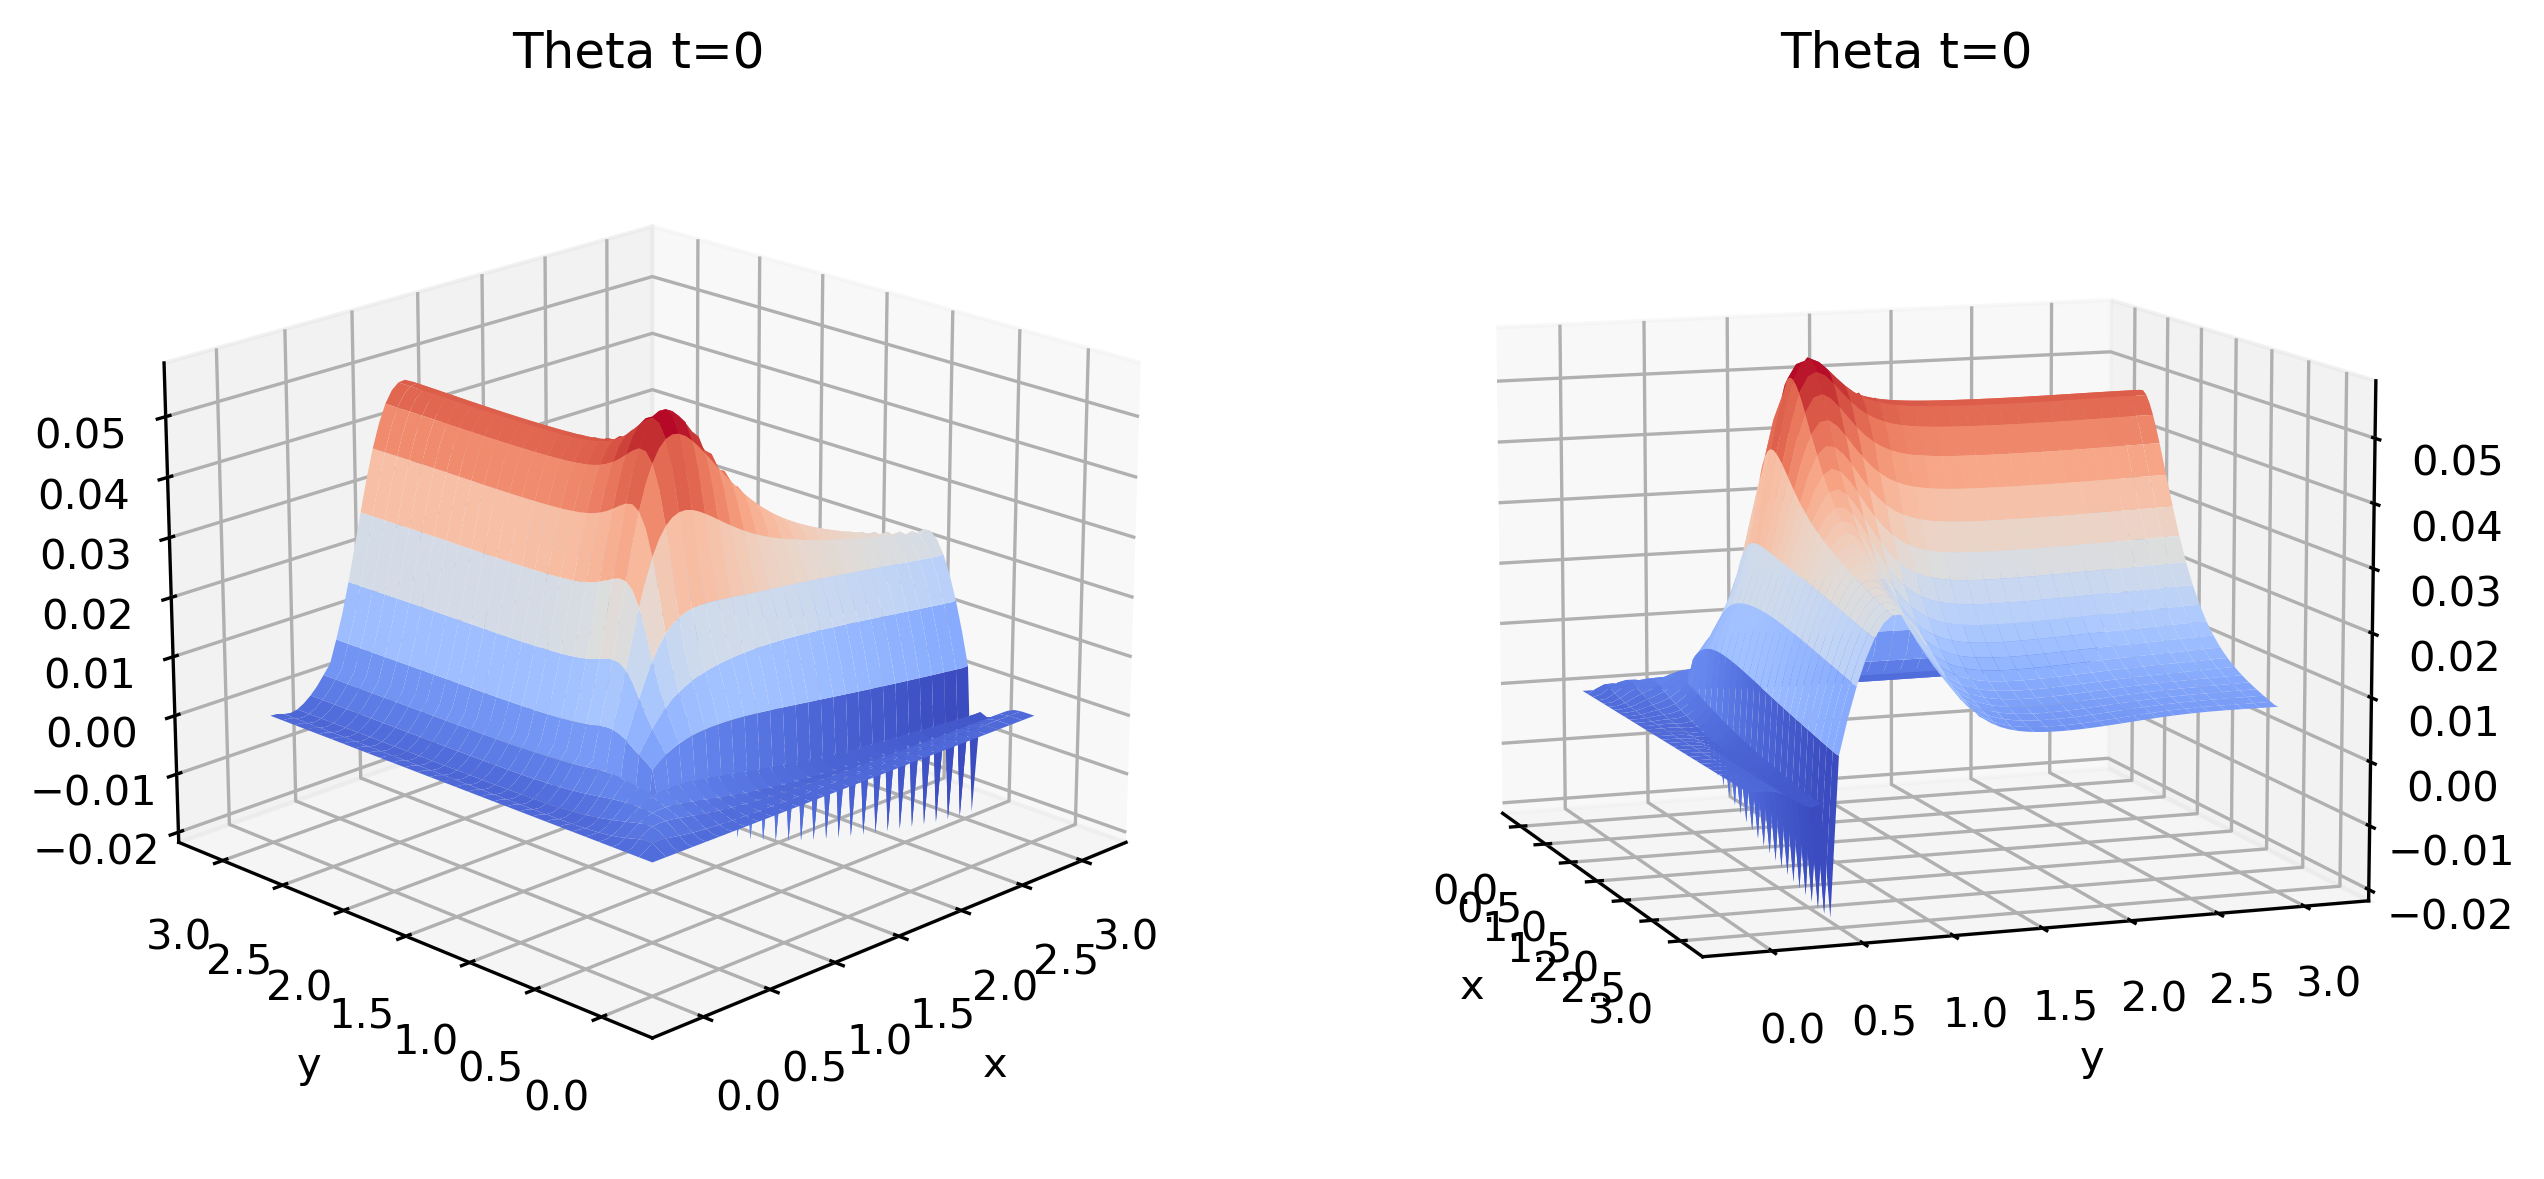

In [15]:
# No KI ELS
X,Y = np.meshgrid(x,y)
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')
surf0 = ax0.plot_surface(X, Y, theta, cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(X, Y, theta, cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(20, -135)
ax1.view_init(10, -20) 
# ax0.set_zlim3d(0.0, 120.0)
# ax1.set_zlim3d(0.0, 120.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('Theta t=0')
ax1.set_title('Theta t=0')


14.507938634486123
-0.09872945837906275


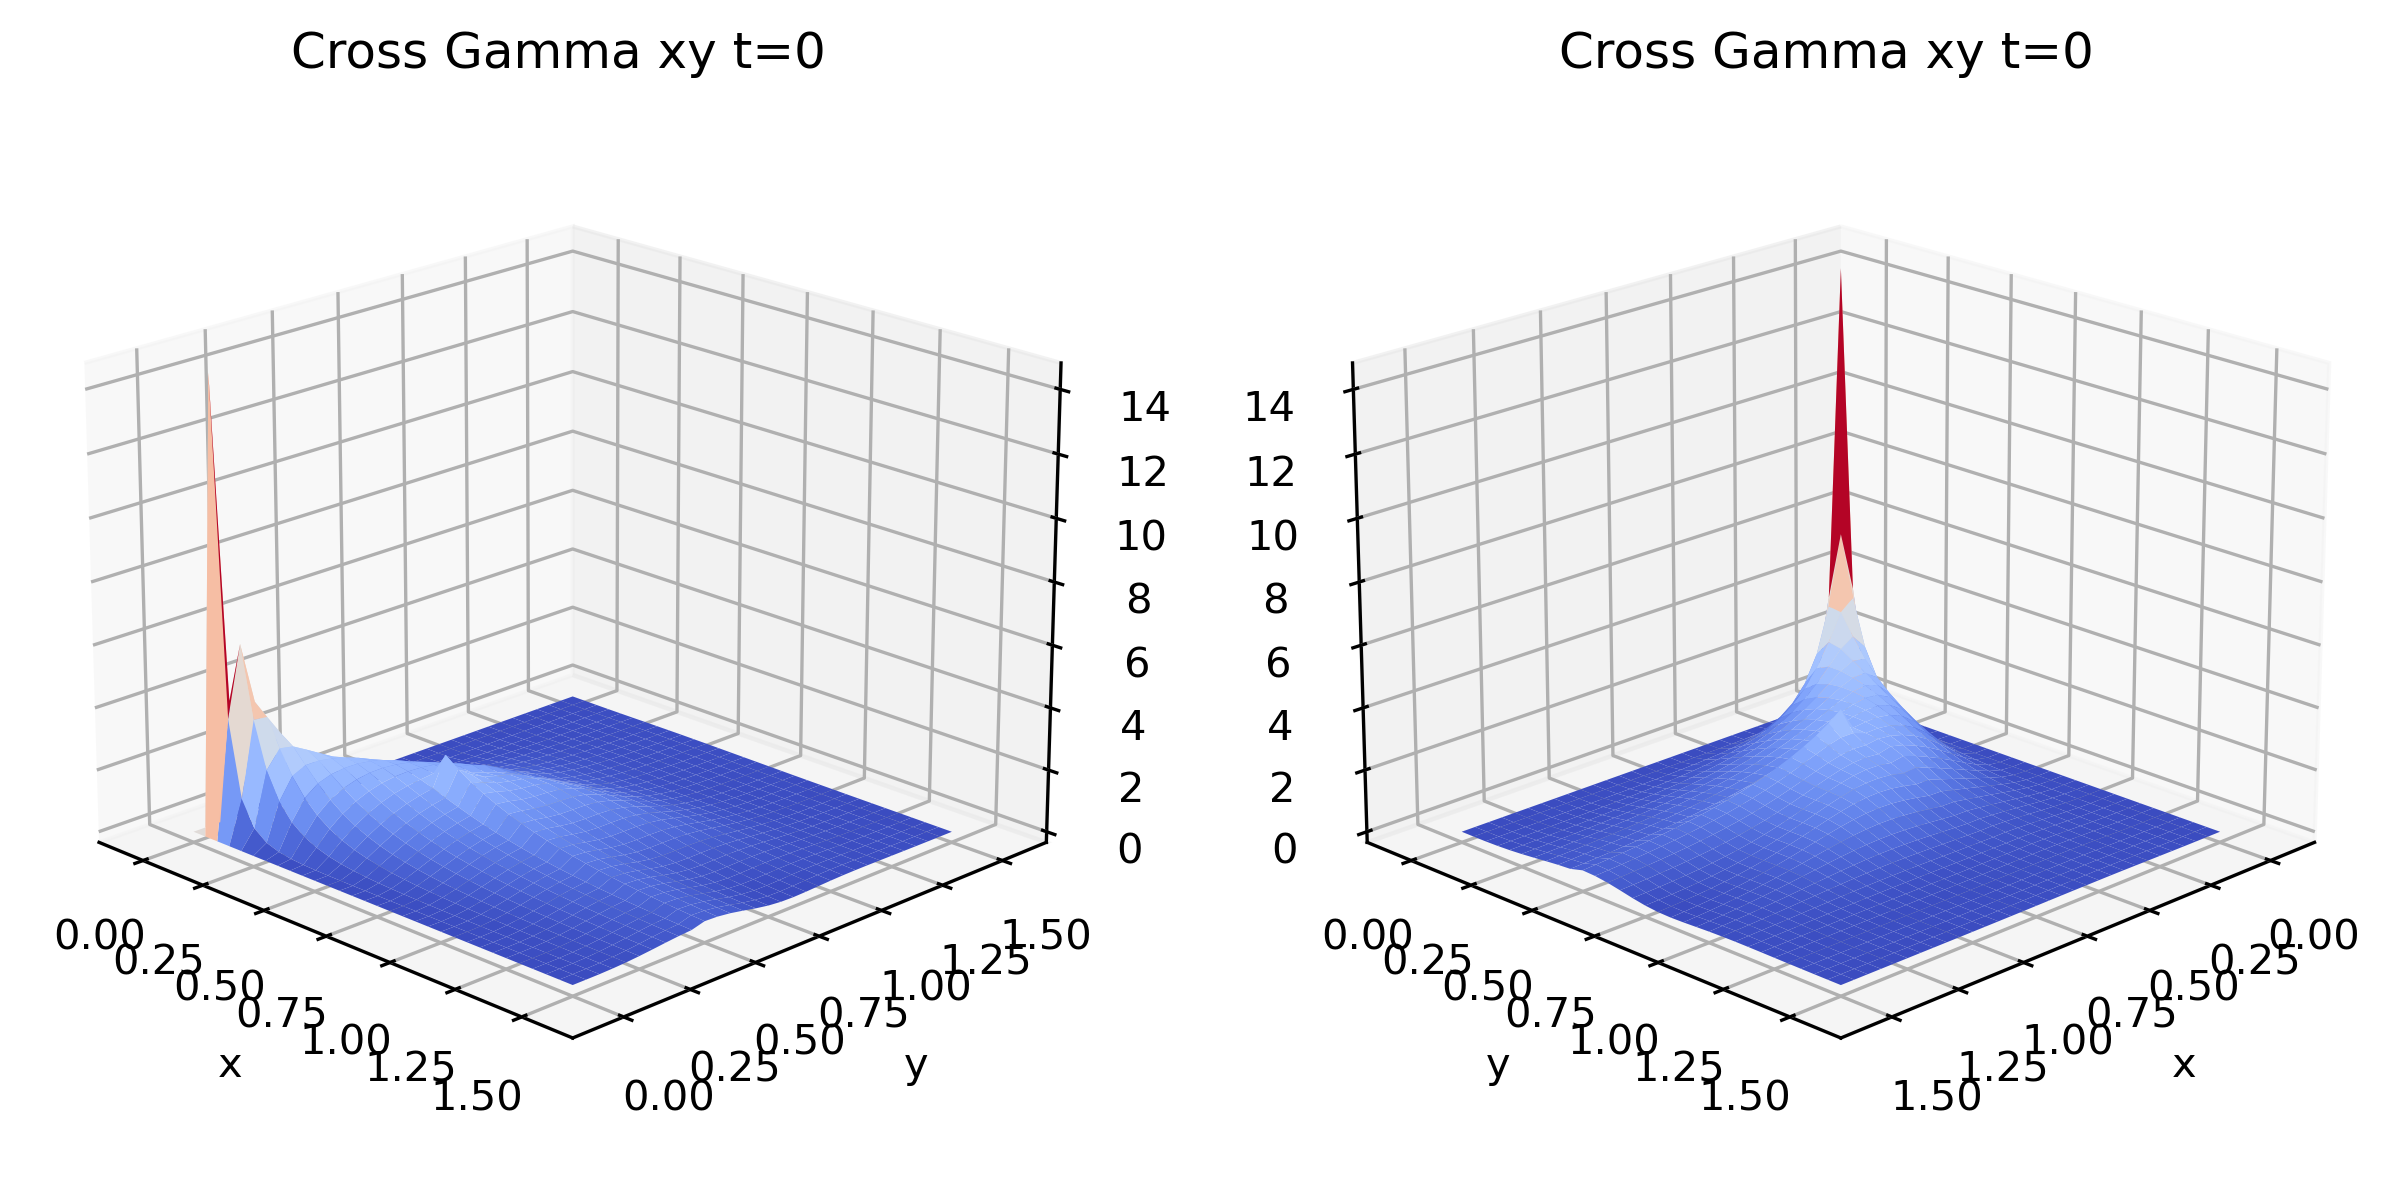

In [16]:
# No KI ELS
# X,Y = np.meshgrid(x[5:],y[5:])
X,Y = np.meshgrid(x[:31],y[:31])
fig1 = plt.figure(figsize=(10,10))
ax0 = fig1.add_subplot(121, projection='3d')
ax1 = fig1.add_subplot(122, projection='3d')
# surf0 = ax0.plot_surface(X, Y, crossgamma[5:,5:], cmap=plt.cm.coolwarm)
# surf1 = ax1.plot_surface(X, Y, crossgamma[5:,5:], cmap=plt.cm.coolwarm)
surf0 = ax0.plot_surface(X, Y, kcrossgammas[-1][:31, :31], cmap=plt.cm.coolwarm)
surf1 = ax1.plot_surface(X, Y, kcrossgammas[-1][:31, :31], cmap=plt.cm.coolwarm)

# ax0.view_init(31, -134)
ax0.view_init(20, -45)
ax1.view_init(20, 45) 
# ax0.set_zlim3d(0.0, 120.0)
# ax1.set_zlim3d(0.0, 120.0)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax0.set_title('Cross Gamma xy t=0')
ax1.set_title('Cross Gamma xy t=0')
print(np.max(kcrossgammas[-1][:,:]))
print(np.min(kcrossgammas[-1][:,:]))